# INITIAL VALIDATION RESULTS ANALYSIS - WITH OVERSAMPLING

In this notebook we will look in some depth into the initial results obtained on the S4 sample validation subset (25% of the samples).

We need to understand, mainly the following two questions:

- Why so many non-pulsating records are misclassified as pulsating?
- Is there any `predict_proba` threshold that would give us certainty about a validation star being pulsating?

## Modules and configuration

### Modules

In [1]:
import pandas as pd

from astropy.table import QTable
from astropy import units

from sklearn.metrics import precision_score, confusion_matrix

import pickle

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
RESULTS_SUMMARY_FILE = "ModelPreselection_PrecisionResults_OversampledSMOTE_n3.csv"
PREDICTIONS_FILE = "ModelPreselection_ValidationPredictions_OversampledSMOTE_n3.csv"

S4_METADATA_FILE = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S4.csv"
S4_RV_CURVES_INFO_FILE = "../data/SYNTH_RV_SAMPLES/RV_FINAL_ML_SyntheticDatasets.csv"

REL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"
UNREL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Unreliable_features.pickle"

MODELS_FOLDER = "../data/ML_MODELS/ML_model_preselection/"

ADD_META_COLUMNS = [
    'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints',
    'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale',
    'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev'
]

IMG_FOLDER = "./img/"

### Functions

In [3]:
def calculate_std_astropy(rvfile=None):
    '''Calculates the 'std' value of a Time series stored in the file passed as parameter, 
    with astropy module.
    Returns just the value (i.e. not the 'Quantity' type)
    '''
    if rvfile is None:
        return None
    else:
        # Read QTtable:
        astpy = QTable.read(rvfile,
                            format='ascii', delimiter=' ',
                            names=['BJD', 'RV', 'RV_error'],
                            units=[units.d, units.m/units.s, units.m/units.s])
        # Extract the rmse (std) value:
        astropy_std = units.Quantity(astpy['RV'].info(['stats'], out=None)['std']).value
        return astropy_std

In [2]:
def compare_dist(data, x_col, hue_col=None, varname=None, fig_title=None, fig_filename=None,
                 stat='count', kde=False, hist_fill=True, bins='auto'):
    '''Plots and saves overlapped histograms.
    Changed to use the new functions, instead of the deprecated "distplot"
    **NOTE: this would be better with a **kwargs argument'''
    # Plots and saves the figure
    #kwargs = dict(kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
    #              kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,7))
    ax = sns.histplot(data, x=x_col, hue=hue_col, stat=stat, common_norm=False,
                      kde=kde, fill=hist_fill, bins=bins, alpha=0.25)
    if varname is None:
        ax.set_xlabel(x_col, fontsize=12)
    else:
        ax.set_xlabel(varname, fontsize=12)
    ax.set_xlim(0.0, 1.0)
    if fig_title is None:
        ax.set_title("Comparison of distributions", fontsize=16)
    else:
        ax.set_title(fig_title, fontsize=16)
    ax.set_ylabel('Frequency of occurrence', fontsize=12)
    #ax.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        ax.get_figure().savefig(fig_filename, format='jpg');

In [5]:
def pred_proba_plot(data, clf_name, y_var=None, pred_col=None, true_col=None, prob_threshold=0.5,
                    xlabel=None, ylabel=None, fig_title=None, fig_filename=None):
    '''Plots 'predict_proba' for a binary classifier versus other variables,
    also distinguising true and predicted values.
    Note: the 'data' must have a column with the name 'PredictionProb_<clf_name>', which
    contains the 'predict_proba' values for the classifier.
    **Warning: pass a copy of your source 'data' if you don't want the predictions modified as
    per 'prob_threshold'.
    '''
    
    pred_proba_column = 'PredictionProb_' + clf_name
    if y_var is None:
        y_var = 'Prediction_' + clf_name
    # Calculate the new predicted values (as per the threshold):
    if pred_col is None:
        pass
    else:
        data[pred_col] = data[pred_proba_column] \
            .map(lambda x: 1 if x > prob_threshold else 0)
    # Calculate TP, FP, TN, FN:
    conf_mtx = confusion_matrix(data[true_col], data[pred_col])
    tp = conf_mtx[1, 1]
    fp = conf_mtx[0, 1]
    tn = conf_mtx[0, 0]
    fn = conf_mtx[1, 0]
    precision_p = precision_score(data[true_col], data[pred_col])
    
    plt.figure(figsize=(10,7))
    ax = sns.scatterplot(
        data=data,
        x=pred_proba_column, y=y_var,
        hue=pred_col,
        style=true_col,
        alpha=0.75
    )
    ax.axvline(x=prob_threshold, color='grey', ls='--', label="Decision threshold")
    ax.figure.set_figwidth(10)
    ax.figure.set_figheight(7)
    ax.set_xlim(0,1)
    if fig_title is None:
        title = pred_proba_column + " vs " + y_var + "\n"
    else:
        title = fig_title + "\n"
    title += "Precision (pulsating): %.2f | TP: %d; FP: %d; TN: %d; FN: %d" \
        %(precision_p, tp, fp, tn, fn)
    ax.set_title(title, fontsize=16)
    if xlabel is None:
        ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    else:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel is None:
        ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    else:
        ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(loc='best')
#    if fig_filename is None:
#        pass
#    else:
#        plt.savefig(fig_filename, format='jpg');
    if fig_filename is None:
        pass
    else:
        ax.get_figure().savefig(fig_filename, format='jpg');
    plt.plot();

## Load data

### Load reliable features

In [6]:
REL_FEATURES_IN

'../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle'

In [7]:
rel_features = pickle.load(open(REL_FEATURES_IN, 'rb'))
print(rel_features)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'med_double_to_single_step', 'n_epochs', 'std_double_to_single_step', 'total_time', 'percent_beyond_1_std', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4', 'freq3_rel_phase2', 'freq3_rel_phase3', '

In [8]:
UNREL_FEATURES_IN

'../data/ML_MODELS/ML_pipeline_steps/Unreliable_features.pickle'

In [9]:
unrel_features = pickle.load(open(UNREL_FEATURES_IN, 'rb'))
print(unrel_features)

['avg_err', 'avgt', 'mean', 'med_err', 'std_err', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'max_slope', 'maximum', 'median', 'median_absolute_deviation', 'minimum', 'percent_amplitude', 'percent_close_to_median', 'percent_difference_flux_percentile', 'period_fast', 'qso_log_chi2_qsonu', 'qso_log_chi2nuNULL_chi2nu', 'skew', 'std', 'stetson_j', 'stetson_k', 'weighted_average', 'fold2P_slope_10percentile', 'fold2P_slope_90percentile', 'freq1_amplitude1', 'freq1_amplitude2', 'freq1_amplitude3', 'freq1_amplitude4', 'freq1_freq', 'freq1_lambda', 'freq1_signif', 'freq2_amplitude1', 'freq2_amplitude2', 'freq2_amplitude3', 'freq2_amplitude4', 'freq2_freq', 'freq3_amplitude1', 'freq3_amplitude2', 'freq3_amplitude3', 'freq3_amplitude4', 'freq3_freq', 'freq_amplitude_ratio_21', 'freq_amplitude_ratio_31', 'freq_frequency_ratio_21', 'freq_frequency_ratio_31', 'freq_model_max

### Load S4 training / validation results

In [10]:
MODELS_FOLDER + RESULTS_SUMMARY_FILE

'../data/ML_MODELS/ML_model_preselection/ModelPreselection_PrecisionResults_OversampledSMOTE_n3.csv'

In [11]:
val_results = pd.read_csv(MODELS_FOLDER + RESULTS_SUMMARY_FILE, sep=',', decimal='.')
val_results

Classifier  BM_tr_precision  BM_val_precision  \
0                   Perceptron         0.631130          0.102564   
1           LogisticRegression         0.662739          0.087379   
2  PassiveAggressiveClassifier         0.650826          0.102273   
3                          SVC         0.934473          0.139535   
4         KNeighborsClassifier         0.765376          0.113208   
5    GaussianProcessClassifier         1.000000          0.108108   
6       DecisionTreeClassifier         1.000000          0.075758   
7       RandomForestClassifier         1.000000          0.200000   
8           AdaBoostClassifier         0.870370          0.132075   
9   GradientBoostingClassifier         0.969298          0.095238   

   BMOPT_tr_precision  BMOPT_val_precision  
0            0.620387             0.093023  
1            0.665685             0.076923  
2            0.624526             0.104000  
3            0.972344             0.193548  
4            1.000000             0.117647  
5            0.976436             0.133333  
6            0.950525             0.120690  
7            0.989410             0.055556  
8            0.919355             0.140000  
9            0.841954             0.086957

### Load S4 validation predictions

In [12]:
MODELS_FOLDER + PREDICTIONS_FILE

'../data/ML_MODELS/ML_model_preselection/ModelPreselection_ValidationPredictions_OversampledSMOTE_n3.csv'

In [13]:
val_pred = pd.read_csv(MODELS_FOLDER + PREDICTIONS_FILE, sep=',', decimal='.')
val_pred

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00107          0        0.0          0.0       0.0  2.457430e+06   
1    Star-00868          0        0.0          0.0       0.0  2.457432e+06   
2    Star-00106          0        0.0          0.0       0.0  2.457404e+06   
3    Star-00120          0        0.0          0.0       0.0  2.457395e+06   
4    Star-00559          0        0.0          0.0       0.0  2.457441e+06   
..          ...        ...        ...          ...       ...           ...   
245  Star-00232          0        0.0          0.0       0.0  2.457436e+06   
246  Star-00943          0        0.0          0.0       0.0  2.457418e+06   
247  Star-00721          0        0.0          0.0       0.0  2.457398e+06   
248  Star-00926          0        0.0          0.0       0.0  2.457425e+06   
249  Star-00129          0        0.0          0.0       0.0  2.458603e+06   

     phase  all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
0      0.0                 -0.991660                   0.031948   
1      0.0                 -1.309194                  -1.081711   
2      0.0                 -0.356591                   0.379966   
3      0.0                 -0.039057                   0.519174   
4      0.0                  0.596012                  -0.664089   
..     ...                       ...                        ...   
245    0.0                  0.913546                   0.101552   
246    0.0                  0.278478                  -0.733692   
247    0.0                 -0.356591                   1.493625   
248    0.0                  0.913546                  -1.151314   
249    0.0                 -0.039057                  -0.594485   

     all_times_nhist_peak2_bin  ...  PredictionProb_Perceptron  \
0                     0.542146  ...                        NaN   
1                     1.825039  ...                        NaN   
2                     0.844003  ...                        NaN   
3                     0.994931  ...                        NaN   
4                    -0.212498  ...                        NaN   
..                         ...  ...                        ...   
245                  -1.419927  ...                        NaN   
246                   1.447717  ...                        NaN   
247                   1.221324  ...                        NaN   
248                   0.240288  ...                        NaN   
249                   0.994931  ...                        NaN   

     PredictionProb_LogisticRegression  \
0                             0.144057   
1                             0.195229   
2                             0.452925   
3                             0.384932   
4                             0.401998   
..                                 ...   
245                           0.413157   
246                           0.199801   
247                           0.542321   
248                           0.307568   
249                           0.417450   

     PredictionProb_PassiveAggressiveClassifier  PredictionProb_SVC  \
0                                           NaN                 NaN   
1                                           NaN                 NaN   
2                                           NaN                 NaN   
3                                           NaN                 NaN   
4                                           NaN                 NaN   
..                                          ...                 ...   
245                                         NaN                 NaN   
246                                         NaN                 NaN   
247                                         NaN                 NaN   
248                                         NaN                 NaN   
249                                         NaN                 NaN   

     PredictionProb_KNeighborsClassifier  \
0                                    0.0   
1                               

In [14]:
print(list(val_pred.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'mean', 'med_double_to_single_step', 'med_err', 'n_epochs', 'std_double_to_single_step', 'std_err', 'total_time', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_perc

#### Drop the features columns

In [15]:
val_pred.drop(
    columns=rel_features + unrel_features, inplace=True)
print(list(val_pred.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_Perceptron', 'PredictionProb_LogisticRegression', 'PredictionProb_PassiveAggressiveClassifier', 'PredictionProb_SVC', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier']


#### Drop the columns of prediction probabilities without values

In [16]:
val_pred.drop(
    columns=['PredictionProb_Perceptron',
             'PredictionProb_PassiveAggressiveClassifier',
             'PredictionProb_SVC'], inplace=True)
print(list(val_pred.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier']


In [17]:
(val_pred['Pulsating'] == 1).sum()

26

In [18]:
MODELS_FOLDER + RESULTS_SUMMARY_FILE

'../data/ML_MODELS/ML_model_preselection/ModelPreselection_PrecisionResults_OversampledSMOTE_n3.csv'

In [19]:
tr_results = pd.read_csv(MODELS_FOLDER + RESULTS_SUMMARY_FILE, sep=',', decimal='.')
tr_results

Classifier  BM_tr_precision  BM_val_precision  \
0                   Perceptron         0.631130          0.102564   
1           LogisticRegression         0.662739          0.087379   
2  PassiveAggressiveClassifier         0.650826          0.102273   
3                          SVC         0.934473          0.139535   
4         KNeighborsClassifier         0.765376          0.113208   
5    GaussianProcessClassifier         1.000000          0.108108   
6       DecisionTreeClassifier         1.000000          0.075758   
7       RandomForestClassifier         1.000000          0.200000   
8           AdaBoostClassifier         0.870370          0.132075   
9   GradientBoostingClassifier         0.969298          0.095238   

   BMOPT_tr_precision  BMOPT_val_precision  
0            0.620387             0.093023  
1            0.665685             0.076923  
2            0.624526             0.104000  
3            0.972344             0.193548  
4            1.000000             0.117647  
5            0.976436             0.133333  
6            0.950525             0.120690  
7            0.989410             0.055556  
8            0.919355             0.140000  
9            0.841954             0.086957

### Load S4 metadata

#### In _cesium_ features file

In [20]:
S4_METADATA_FILE

'../data/DATASETS_CESIUM/cesium_ML_FINAL_S4.csv'

In [21]:
s4_meta = pd.read_csv(S4_METADATA_FILE, sep=',', decimal='.')
s4_meta

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00000       True      10.33         1.14       0.0  2.457582e+06   
1    Star-00001       True      14.92         1.30       0.0  2.457522e+06   
2    Star-00002      False       0.00         0.00       0.0  2.457549e+06   
3    Star-00003      False       0.00         0.00       0.0  2.457460e+06   
4    Star-00004       True      28.74         0.90       0.0  2.457451e+06   
..          ...        ...        ...          ...       ...           ...   
995  Star-00995      False       0.00         0.00       0.0  2.457504e+06   
996  Star-00996      False       0.00         0.00       0.0  2.457673e+06   
997  Star-00997      False       0.00         0.00       0.0  2.458634e+06   
998  Star-00998      False       0.00         0.00       0.0  2.457397e+06   
999  Star-00999      False       0.00         0.00       0.0  2.457406e+06   

     phase  S3_sampling_idx      S3_Tobs  S3_Ps_mean  ...  \
0     0.90               59  1581.730057  158.173006  ...   
1     0.02              129   816.772693   13.389716  ...   
2     0.00              119  1822.043054   28.031432  ...   
3     0.00               65  1890.807762   37.074662  ...   
4     0.29              144  2088.089735   90.786510  ...   
..     ...              ...          ...         ...  ...   
995   0.00              224   742.994588   82.554954  ...   
996   0.00              101   437.841924   87.568385  ...   
997   0.00              173  2289.893365    6.308246  ...   
998   0.00              178  2054.728253   26.684783  ...   
999   0.00              152  1225.824657  136.202740  ...   

     freq_signif_ratio_31  freq_varrat  freq_y_offset  linear_trend  \
0                0.991610     0.194021       0.126036      0.000540   
1                1.003992     0.609698       0.014987      0.001951   
2                0.934956     0.632319      -0.026237     -0.000212   
3                0.962051     0.581716      -0.113978     -0.000015   
4                0.925290     0.222879       0.466669     -0.000863   
..                    ...          ...            ...           ...   
995              1.069798     0.398837      -0.390804     -0.005018   
996              1.173183     0.367422      -0.254162     -0.000684   
997              0.914050     0.922091      -0.019984      0.000061   
998              0.937223     0.791173       0.021598     -0.000637   
999              1.030028     0.146752      -0.016318      0.000204   

    medperc90_2p_p  p2p_scatter_2praw  p2p_scatter_over_mad  \
0         1.178827           0.703403              1.725000   
1         1.106382           1.229017              1.122677   
2         1.158086           0.661486              1.981735   
3         1.221266           0.789303              1.187817   
4         0.883003           0.474592              1.746193   
..             ...                ...                   ...   
995       0.660848           0.306165              2.522293   
996       2.138408           0.926624              1.329268   
997       1.002898           0.914693              1.455446   
998       0.997723           0.829341              1.374893   
999       2.155221           0.835682              1.133333   

     p2p_scatter_pfold_over_mad  p2p_ssqr_diff_over_var  scatter_res_raw  
0                      0.775000                2.721112         0.038931  
1                      0.959108                1.308700         0.304471  
2                      1.150685                2.052008         0.572111  
3                      1.096447                2.098036         0.321233  
4                      0.893401                2.259602         0.189422  
..                          ...                     ...              ...  
995                    2.114650                1.938955         0.505487  
996                    1.329268                2.900075         0.105953  
997                    1.643564                2.014196   

In [22]:
print(list(s4_meta.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'VALID_RECORD', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_p

#### In RV curves info file

In [23]:
S4_RV_CURVES_INFO_FILE

'../data/SYNTH_RV_SAMPLES/RV_FINAL_ML_SyntheticDatasets.csv'

In [24]:
s4_rvinfo = pd.read_csv(S4_RV_CURVES_INFO_FILE, sep=',', decimal='.')
s4_rvinfo

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00000       True      10.33         1.14       0.0  2.457582e+06   
1    Star-00001       True      14.92         1.30       0.0  2.457522e+06   
2    Star-00002      False       0.00         0.00       0.0  2.457549e+06   
3    Star-00003      False       0.00         0.00       0.0  2.457460e+06   
4    Star-00004       True      28.74         0.90       0.0  2.457451e+06   
..          ...        ...        ...          ...       ...           ...   
995  Star-00995      False       0.00         0.00       0.0  2.457504e+06   
996  Star-00996      False       0.00         0.00       0.0  2.457673e+06   
997  Star-00997      False       0.00         0.00       0.0  2.458634e+06   
998  Star-00998      False       0.00         0.00       0.0  2.457397e+06   
999  Star-00999      False       0.00         0.00       0.0  2.457406e+06   

     phase   S1_Ps  S1_Tobs  S2_errorRV_dist_idx  ... S3_Ps_median  \
0     0.90  0.0016    100.0                  209  ...    12.486990   
1     0.02  0.0016    100.0                   78  ...     3.807657   
2     0.00  0.0016    100.0                  218  ...    10.074961   
3     0.00  0.0016    100.0                   28  ...    15.987473   
4     0.29  0.0016    100.0                    6  ...    26.947282   
..     ...     ...      ...                  ...  ...          ...   
995   0.00  0.0016    100.0                   25  ...    25.953213   
996   0.00  0.0016    100.0                  203  ...     7.031455   
997   0.00  0.0016    100.0                   50  ...     2.002482   
998   0.00  0.0016    100.0                  197  ...     9.023501   
999   0.00  0.0016    100.0                  198  ...    34.903594   

     S3_Ps_stdev  S3_NumPoints  S4_errorRV_mean  S4_errorRV_median  \
0     423.473643            11         1.539091              1.370   
1      30.022301            62         1.550806              1.395   
2      40.909038            66         1.459242              1.245   
3      56.735394            52         1.965385              1.570   
4     162.151502            24         1.342917              1.275   
..           ...           ...              ...                ...   
995    90.327010            10         3.286000              2.290   
996   139.291882             6         1.671667              1.405   
997    16.384223           364         1.656484              1.540   
998    50.228453            78         8.531538              6.655   
999   216.412830            10         1.678000              1.505   

     S4_errorRV_stdev                                            S1_file  \
0            0.466271  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
1            0.434698  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
2            0.581178  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
3            0.980136  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
4            0.285504  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
..                ...                                                ...   
995          1.683533  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
996          0.811776  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
997          0.509895  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
998          3.790626  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   
999          0.437488  ../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...   

                                               S2_file  \
0    ../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...   
1    ../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...   
2    ../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...   
3    ../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...   
4    ../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...   
..                                                 ...   
995  ../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...   
996  ../data/SYNT

In [25]:
print(list(s4_rvinfo.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S1_Ps', 'S1_Tobs', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'S1_file', 'S2_file', 'S3_file', 'S4_file']


### Add S4 metadata to predictions

#### From _cesium_ info

In [26]:
val_pred_prov = val_pred.merge(s4_meta[['ID'] + ADD_META_COLUMNS], how='left', on='ID')
val_pred_prov

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00107          0        0.0          0.0       0.0  2.457430e+06   
1    Star-00868          0        0.0          0.0       0.0  2.457432e+06   
2    Star-00106          0        0.0          0.0       0.0  2.457404e+06   
3    Star-00120          0        0.0          0.0       0.0  2.457395e+06   
4    Star-00559          0        0.0          0.0       0.0  2.457441e+06   
..          ...        ...        ...          ...       ...           ...   
245  Star-00232          0        0.0          0.0       0.0  2.457436e+06   
246  Star-00943          0        0.0          0.0       0.0  2.457418e+06   
247  Star-00721          0        0.0          0.0       0.0  2.457398e+06   
248  Star-00926          0        0.0          0.0       0.0  2.457425e+06   
249  Star-00129          0        0.0          0.0       0.0  2.458603e+06   

     phase  Prediction_Perceptron  Prediction_LogisticRegression  \
0      0.0                      0                              0   
1      0.0                      1                              0   
2      0.0                      0                              0   
3      0.0                      1                              0   
4      0.0                      0                              0   
..     ...                    ...                            ...   
245    0.0                      0                              0   
246    0.0                      0                              0   
247    0.0                      1                              1   
248    0.0                      0                              0   
249    0.0                      0                              0   

     Prediction_PassiveAggressiveClassifier  ...  S3_Ps_median  S3_Ps_stdev  \
0                                         0  ...      8.496524   198.804473   
1                                         1  ...     15.468968   351.136147   
2                                         0  ...      2.991639    42.269476   
3                                         0  ...     20.972757   130.800882   
4                                         1  ...     10.074961    40.909038   
..                                      ...  ...           ...          ...   
245                                       0  ...      5.012049    33.340808   
246                                       0  ...     20.992644    65.548752   
247                                       1  ...     31.909965   237.200826   
248                                       0  ...      3.024201    35.284675   
249                                       0  ...      7.399682    64.584705   

     S3_NumPoints  S2_errorRV_dist_idx  S2_errorRV_dist_name  \
0              11                  192            genextreme   
1               9                  102              dweibull   
2             118                  230                  beta   
3              22                  226               lognorm   
4              66                  155                  beta   
..            ...                  ...                   ...   
245            53                  103                  beta   
246            10                  226               lognorm   
247            13                  112            genextreme   
248            52                  169              dweibull   
249            51                   43            genextreme   

     S2_errorRV_dist_loc  S2_errorRV_dist_scale  S4_errorRV_mean  \
0               1.355068               0.266191         1.571818   
1               1.532153               0.467346         1.453333   
2               1.102225               1.076078         1.548729   
3               0.774437               0.555610         1.476364   
4               1.120697               0.870322         1.350909   
..                   ...                    ...              ...   
245             1.086141               1.916084         1.499057 

In [27]:
print(list(val_pred_prov.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev']


#### From RV curve info

In [28]:
val_pred_comp = val_pred_prov.merge(s4_rvinfo[['ID', 'S4_file']], how='left', on='ID')
val_pred_comp

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00107          0        0.0          0.0       0.0  2.457430e+06   
1    Star-00868          0        0.0          0.0       0.0  2.457432e+06   
2    Star-00106          0        0.0          0.0       0.0  2.457404e+06   
3    Star-00120          0        0.0          0.0       0.0  2.457395e+06   
4    Star-00559          0        0.0          0.0       0.0  2.457441e+06   
..          ...        ...        ...          ...       ...           ...   
245  Star-00232          0        0.0          0.0       0.0  2.457436e+06   
246  Star-00943          0        0.0          0.0       0.0  2.457418e+06   
247  Star-00721          0        0.0          0.0       0.0  2.457398e+06   
248  Star-00926          0        0.0          0.0       0.0  2.457425e+06   
249  Star-00129          0        0.0          0.0       0.0  2.458603e+06   

     phase  Prediction_Perceptron  Prediction_LogisticRegression  \
0      0.0                      0                              0   
1      0.0                      1                              0   
2      0.0                      0                              0   
3      0.0                      1                              0   
4      0.0                      0                              0   
..     ...                    ...                            ...   
245    0.0                      0                              0   
246    0.0                      0                              0   
247    0.0                      1                              1   
248    0.0                      0                              0   
249    0.0                      0                              0   

     Prediction_PassiveAggressiveClassifier  ...  S3_Ps_stdev  S3_NumPoints  \
0                                         0  ...   198.804473            11   
1                                         1  ...   351.136147             9   
2                                         0  ...    42.269476           118   
3                                         0  ...   130.800882            22   
4                                         1  ...    40.909038            66   
..                                      ...  ...          ...           ...   
245                                       0  ...    33.340808            53   
246                                       0  ...    65.548752            10   
247                                       1  ...   237.200826            13   
248                                       0  ...    35.284675            52   
249                                       0  ...    64.584705            51   

     S2_errorRV_dist_idx  S2_errorRV_dist_name  S2_errorRV_dist_loc  \
0                    192            genextreme             1.355068   
1                    102              dweibull             1.532153   
2                    230                  beta             1.102225   
3                    226               lognorm             0.774437   
4                    155                  beta             1.120697   
..                   ...                   ...                  ...   
245                  103                  beta             1.086141   
246                  226               lognorm             0.774437   
247                  112            genextreme             1.411556   
248                  169              dweibull             1.178147   
249                   43            genextreme             1.272194   

     S2_errorRV_dist_scale  S4_errorRV_mean  S4_errorRV_median  \
0                 0.266191         1.571818              1.430   
1                 0.467346         1.453333              1.380   
2                 1.076078         1.548729              1.500   
3                 0.555610         1.476364              1.325   
4                 0.870322         1.350909              1.330   
..                     ...              ...                ..

In [29]:
print(list(val_pred_comp.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'S4_file']


### Calculate RMS of the RV curves

In [30]:
val_pred_comp['RV_RMS'] = val_pred_comp['S4_file'].map(lambda x: calculate_std_astropy(x))
val_pred_comp

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00107          0        0.0          0.0       0.0  2.457430e+06   
1    Star-00868          0        0.0          0.0       0.0  2.457432e+06   
2    Star-00106          0        0.0          0.0       0.0  2.457404e+06   
3    Star-00120          0        0.0          0.0       0.0  2.457395e+06   
4    Star-00559          0        0.0          0.0       0.0  2.457441e+06   
..          ...        ...        ...          ...       ...           ...   
245  Star-00232          0        0.0          0.0       0.0  2.457436e+06   
246  Star-00943          0        0.0          0.0       0.0  2.457418e+06   
247  Star-00721          0        0.0          0.0       0.0  2.457398e+06   
248  Star-00926          0        0.0          0.0       0.0  2.457425e+06   
249  Star-00129          0        0.0          0.0       0.0  2.458603e+06   

     phase  Prediction_Perceptron  Prediction_LogisticRegression  \
0      0.0                      0                              0   
1      0.0                      1                              0   
2      0.0                      0                              0   
3      0.0                      1                              0   
4      0.0                      0                              0   
..     ...                    ...                            ...   
245    0.0                      0                              0   
246    0.0                      0                              0   
247    0.0                      1                              1   
248    0.0                      0                              0   
249    0.0                      0                              0   

     Prediction_PassiveAggressiveClassifier  ...  S3_NumPoints  \
0                                         0  ...            11   
1                                         1  ...             9   
2                                         0  ...           118   
3                                         0  ...            22   
4                                         1  ...            66   
..                                      ...  ...           ...   
245                                       0  ...            53   
246                                       0  ...            10   
247                                       1  ...            13   
248                                       0  ...            52   
249                                       0  ...            51   

     S2_errorRV_dist_idx  S2_errorRV_dist_name  S2_errorRV_dist_loc  \
0                    192            genextreme             1.355068   
1                    102              dweibull             1.532153   
2                    230                  beta             1.102225   
3                    226               lognorm             0.774437   
4                    155                  beta             1.120697   
..                   ...                   ...                  ...   
245                  103                  beta             1.086141   
246                  226               lognorm             0.774437   
247                  112            genextreme             1.411556   
248                  169              dweibull             1.178147   
249                   43            genextreme             1.272194   

     S2_errorRV_dist_scale  S4_errorRV_mean  S4_errorRV_median  \
0                 0.266191         1.571818              1.430   
1                 0.467346         1.453333              1.380   
2                 1.076078         1.548729              1.500   
3                 0.555610         1.476364              1.325   
4                 0.870322         1.350909              1.330   
..                     ...              ...                ...   
245               1.916084         1.499057              1.210   
246               0.555610         1.641000              1.450   
247               0

In [31]:
print(list(val_pred_comp.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'S4_file', 'RV_RMS']


## Questions

These are some of the questions we will try to address here, having a look to all the _optimized_ classifiers, so as to decide which one could be the best one to select:

- Is the `predict_proba` (and the correct/incorrect classifications of true pulsating signals) related to some of the following?
  - Amplitude of the pulsation signal.
  - Frequency of the pulsation signal.
  - Median of RV error of the signal.
  - Standard deviation of RV error of the signal.
  - Number of points in the RV curve.
  - Time baseline (`T_obs`).
  - Sampling period median.
  - Sampling period standard deviation.
  - RMS value of the RV curve.
- Could we use  the `predict_proba` threshold to improve performance?

In order to do this, we will draw scatter plots of the `predict_proba` versus the other three variables above, for all the classifiers. We can also distinguish the true positives / true negatives with the marker shape and the predicted positives / predicted negatives with the marker color (for example). Size of the marker could conceivably incorporate a third variable into the plot (one of the three above, the phase, or even some other like curve RMS, etc.).

Let's see if, changing the `predict_proba`threshold, we could improve the situation.

We first draw the distributions of `predict_proba` values, separated by the true class of the validation star.

In [32]:
print(list(val_pred_comp.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'S4_file', 'RV_RMS']


In [33]:
clf_list = [clf.replace("PredictionProb_","") for clf in list(val_pred_comp.columns) if 'PredictionProb_' in clf]
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

### Example

In [34]:
len(val_pred_comp[val_pred_comp['Prediction_LogisticRegression'] == 1])

104

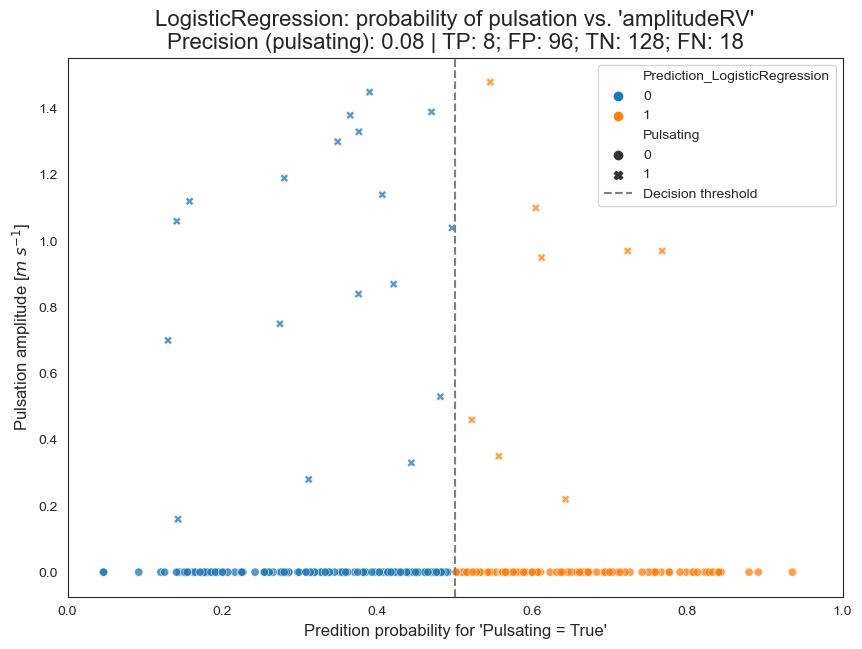

In [35]:
data = val_pred_comp.copy()
clf_name = clf_list[0]
y_var = 'amplitudeRV'
pred_col = 'Prediction_' + clf_name 
true_col = 'Pulsating'
prob_threshold = 0.5
xlabel = "Predition probability for 'Pulsating = True'"
ylabel = "Pulsation amplitude [$m\;s^{-1}$]"
fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
fig_filename = "ML_55_TEST.jpg"


pred_proba_plot(
    data=data, clf_name=clf_name, y_var=y_var,
    pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
)

In [36]:
len(val_pred_comp[val_pred_comp['Prediction_LogisticRegression'] == 1])

104

**Caution:** pass a copy of the data if you don't want the predictions to be altered in your source data.

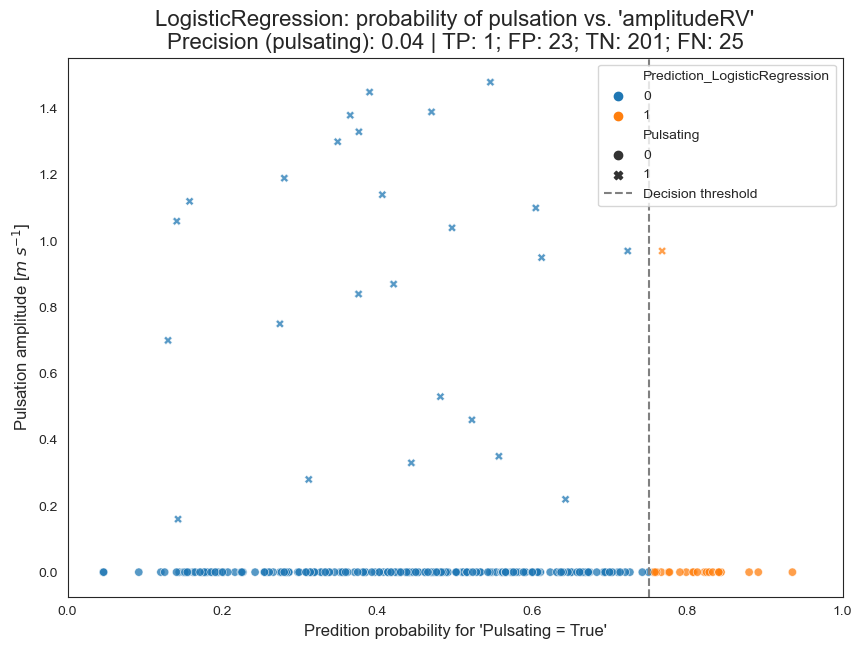

In [37]:
data = val_pred_comp.copy()
clf_name = clf_list[0]
y_var = 'amplitudeRV'
pred_col = 'Prediction_' + clf_name 
true_col = 'Pulsating'
prob_threshold = 0.75
xlabel = "Predition probability for 'Pulsating = True'"
ylabel = "Pulsation amplitude [$m\;s^{-1}$]"
fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
fig_filename = "ML_55_TEST.jpg"


pred_proba_plot(
    data=data, clf_name=clf_name, y_var=y_var,
    pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
)

In [38]:
len(data[data['Prediction_LogisticRegression'] == 1])

24

In [39]:
len(val_pred_comp[val_pred_comp['Prediction_LogisticRegression'] == 1])

104

### Amplitude plots

In [40]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

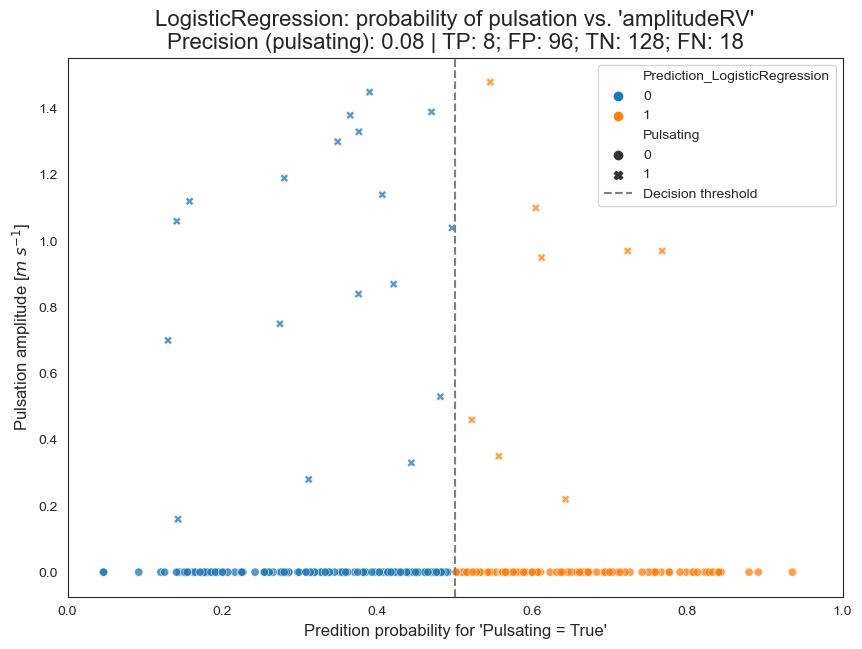

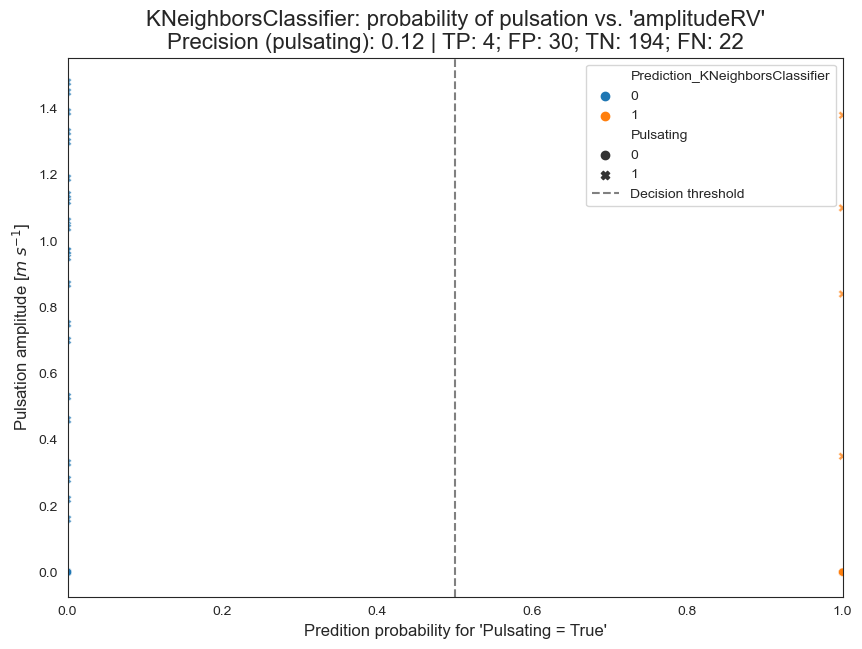

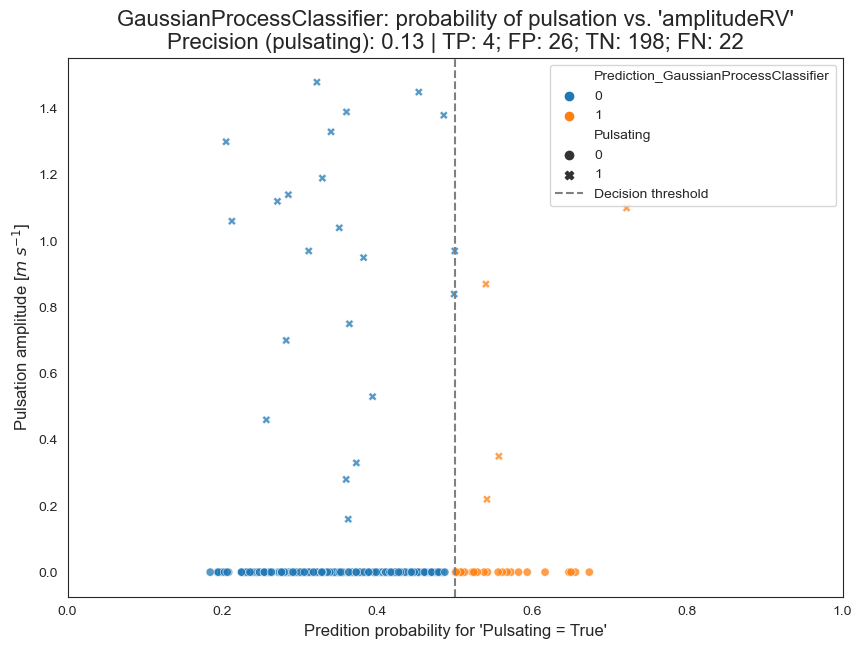

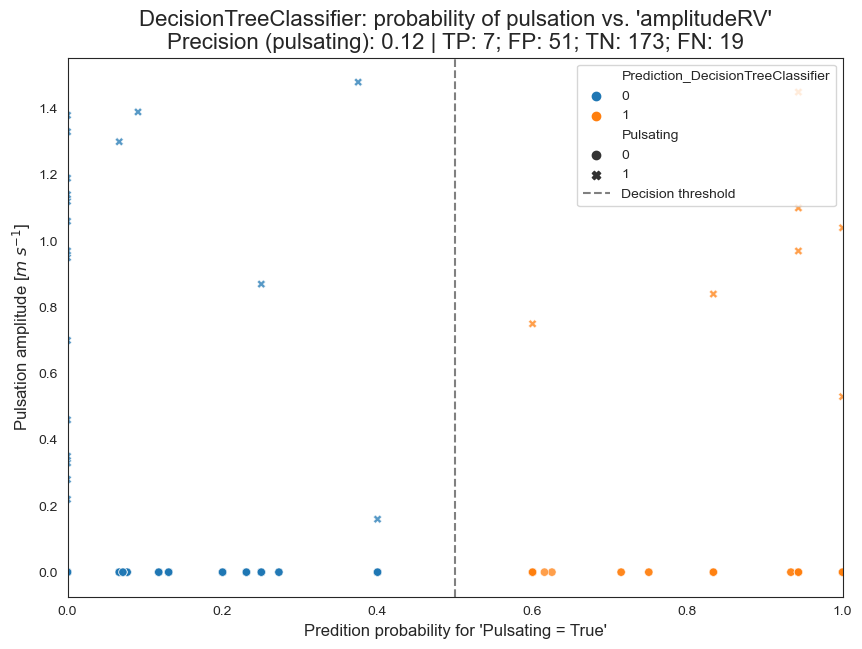

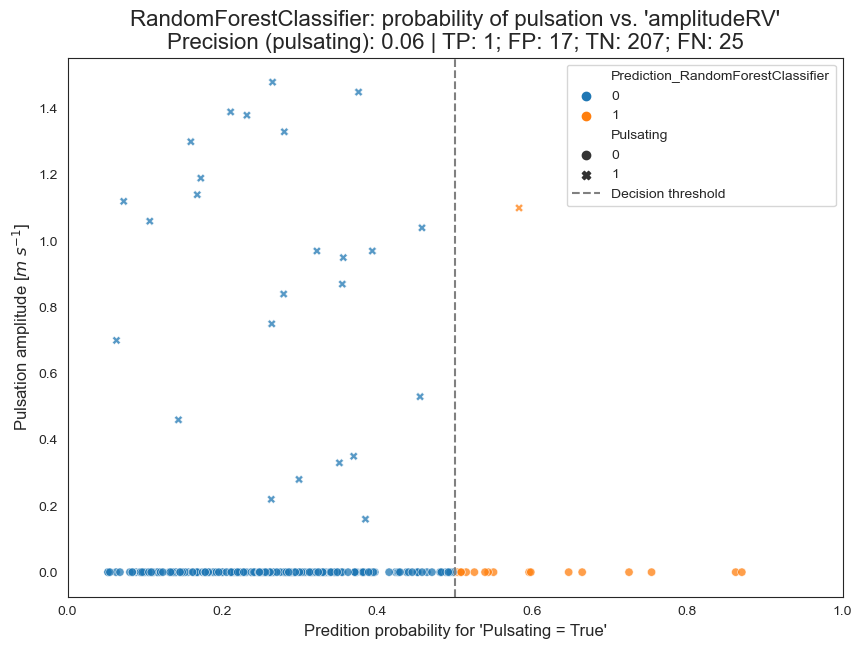

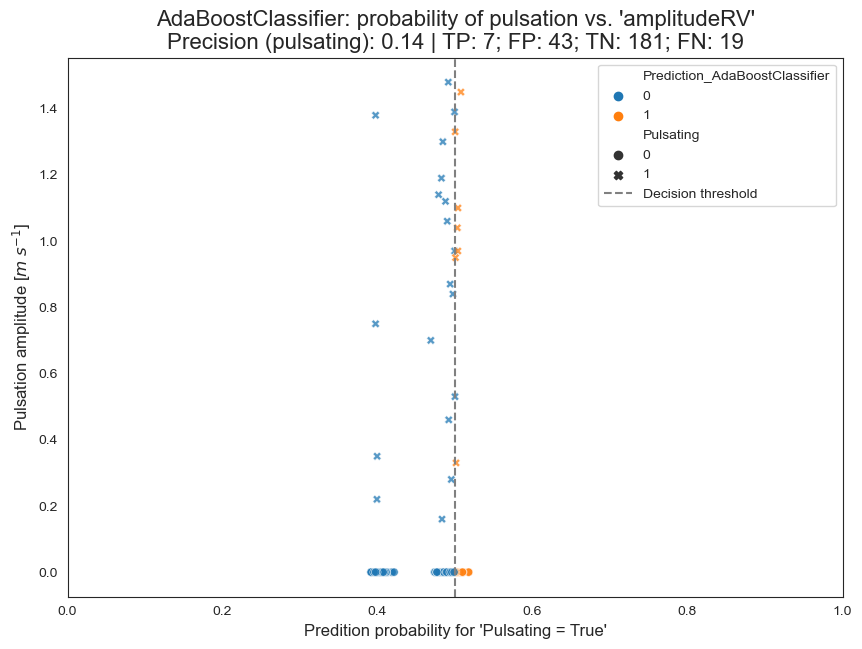

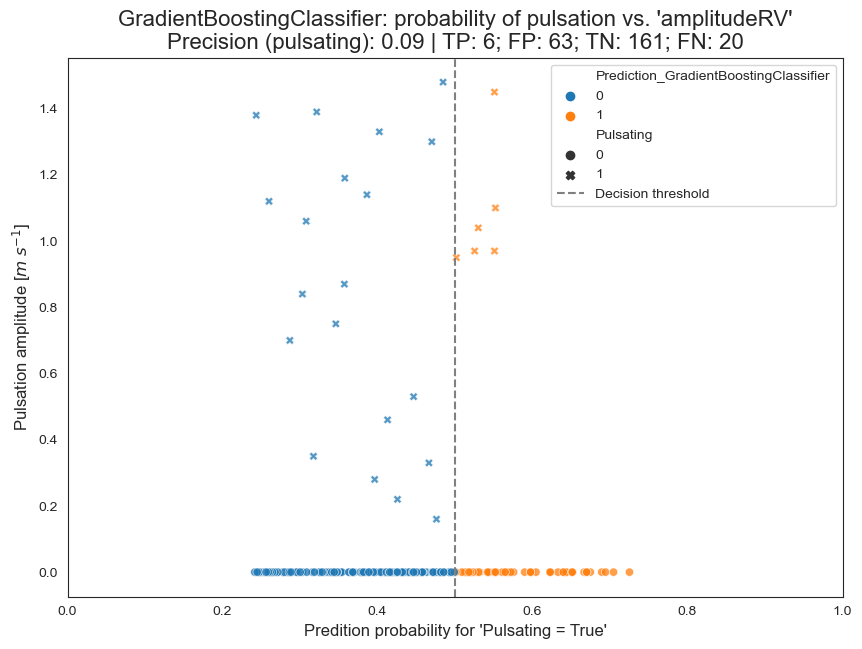

In [41]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'amplitudeRV'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Pulsation amplitude [$m\;s^{-1}$]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_01_" + str(img_id).zfill(2) +"_PredProba_vs_Amp_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Frequency plots

In [42]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

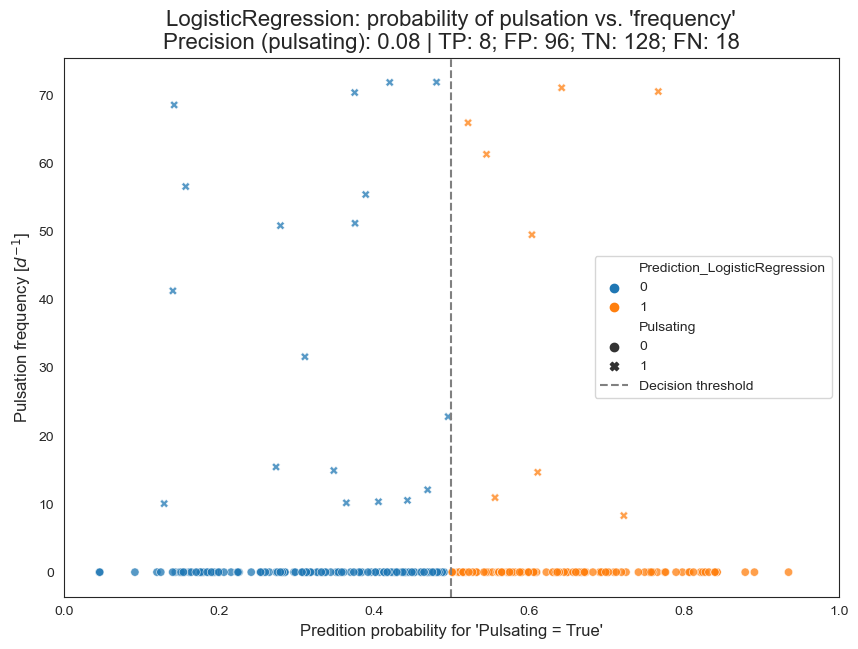

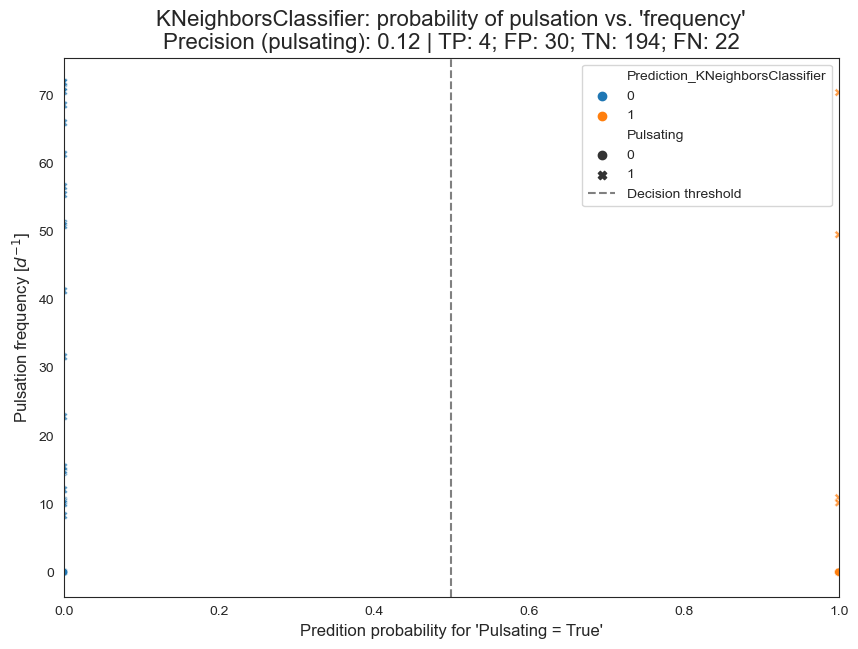

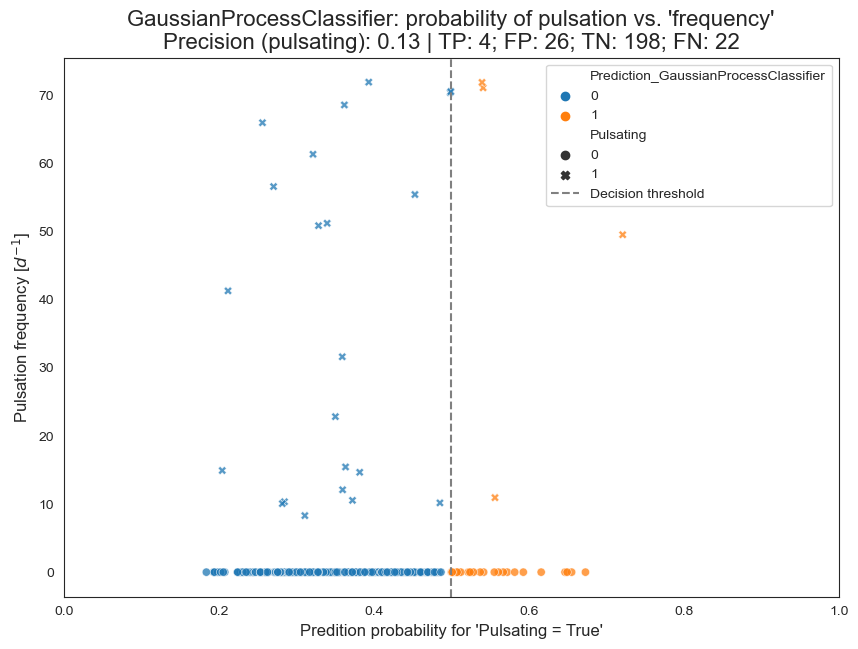

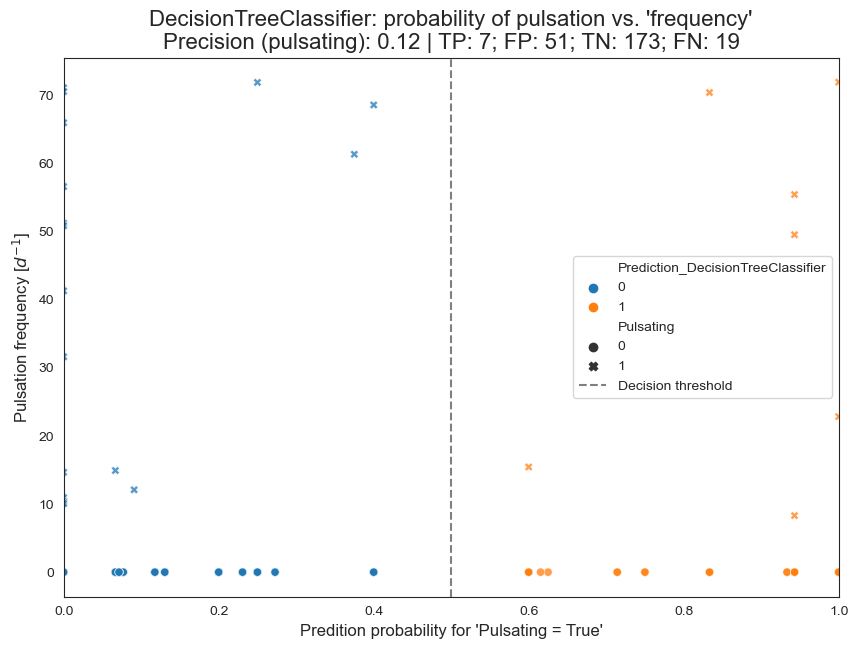

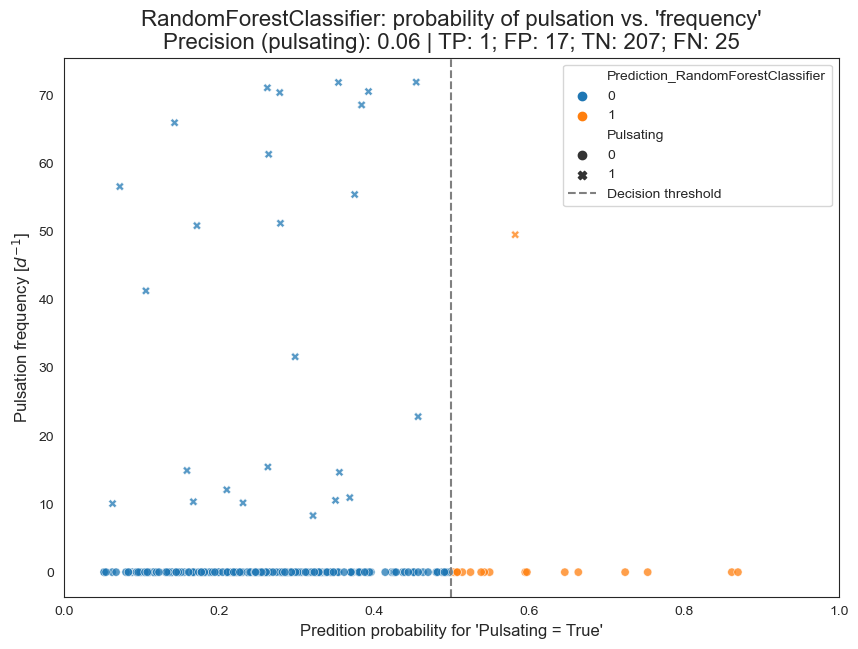

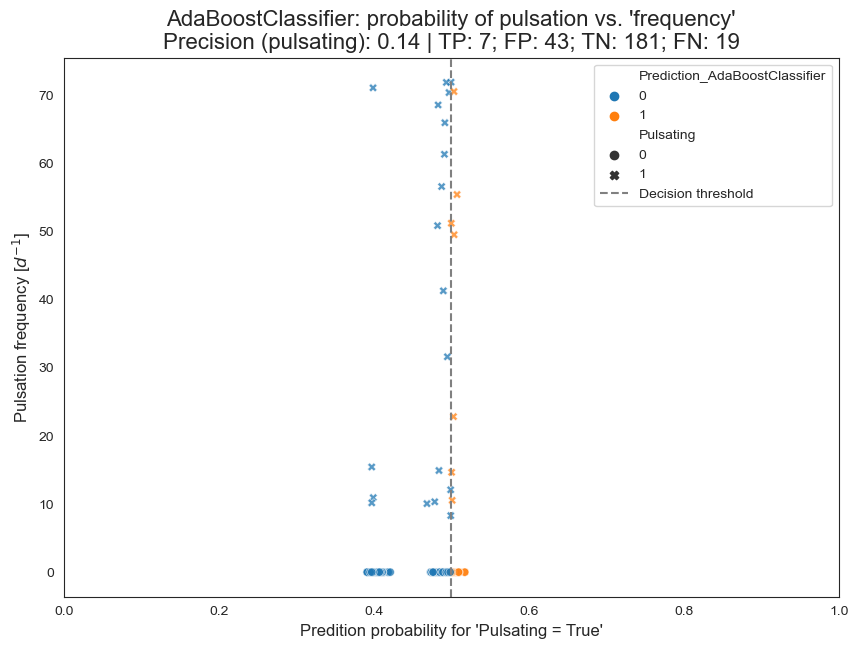

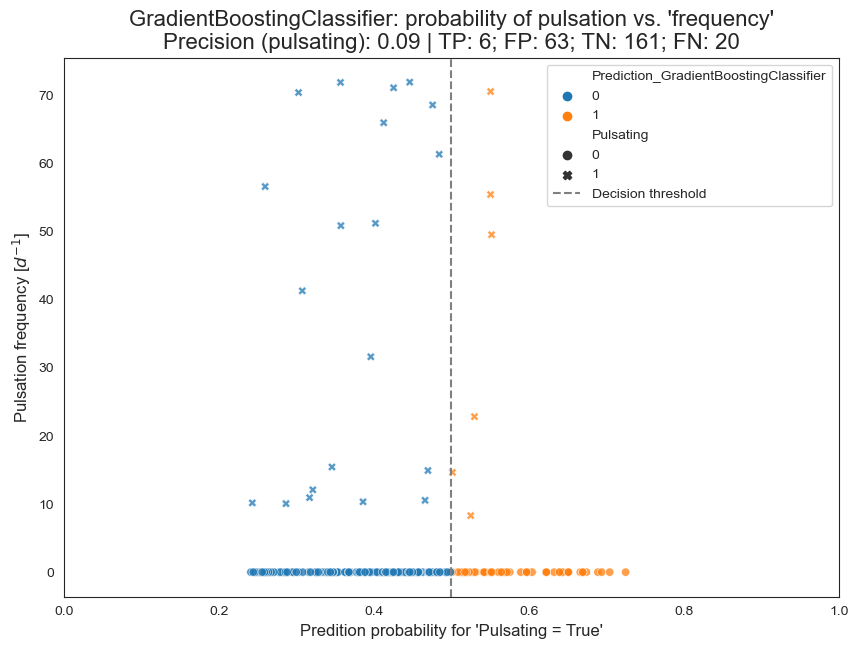

In [43]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'frequency'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Pulsation frequency [$d^{-1}$]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_02_" + str(img_id).zfill(2) +"_PredProba_vs_Freq_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Median of RV error plots

In [44]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

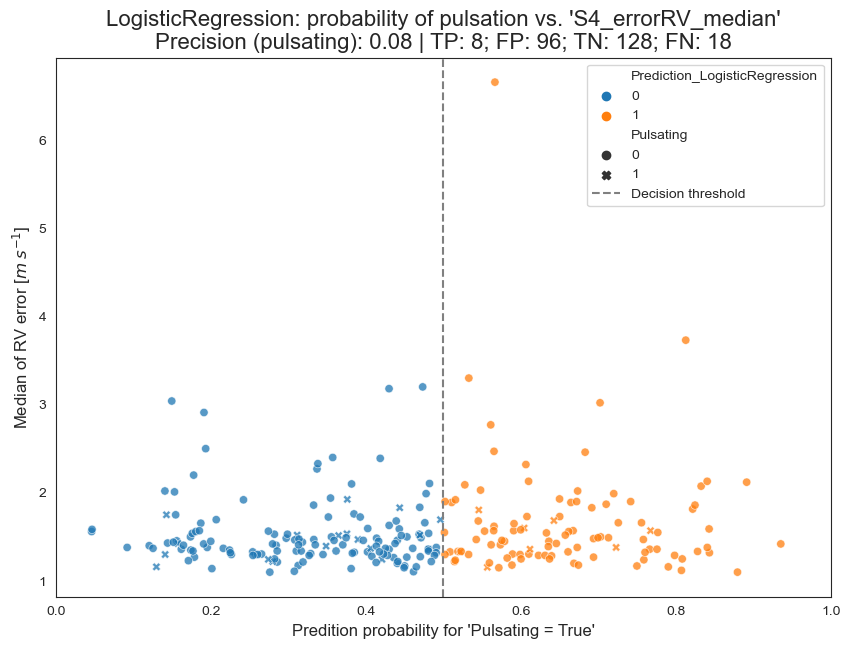

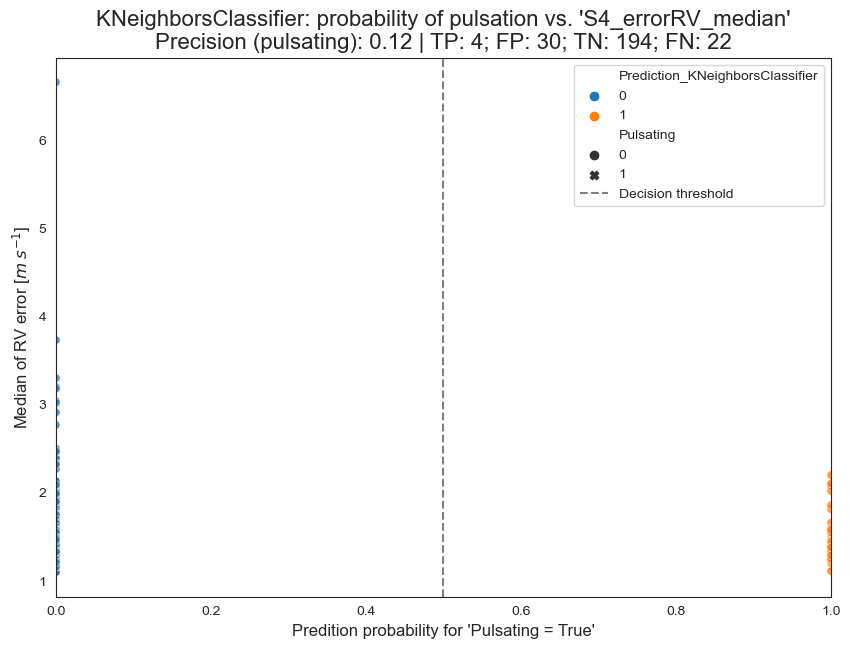

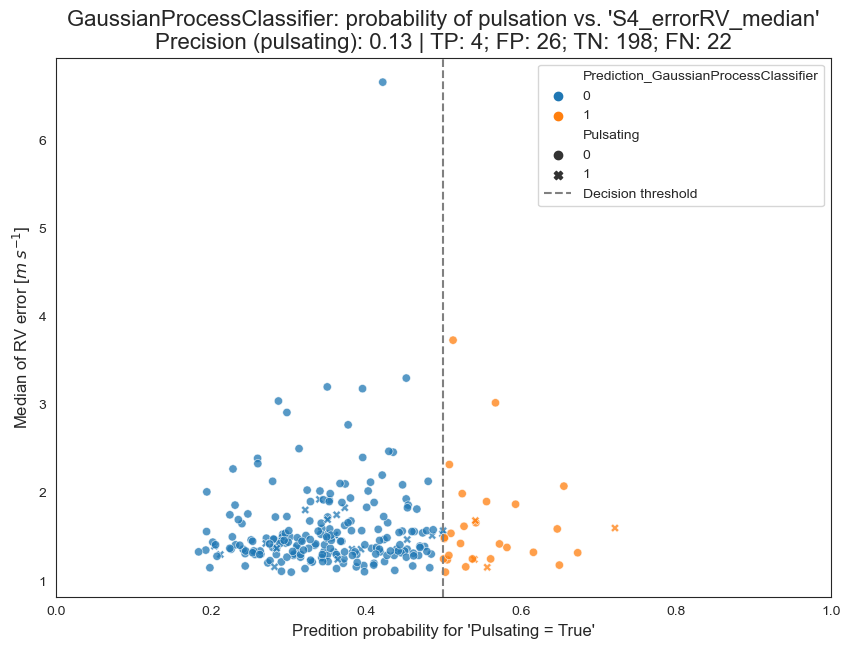

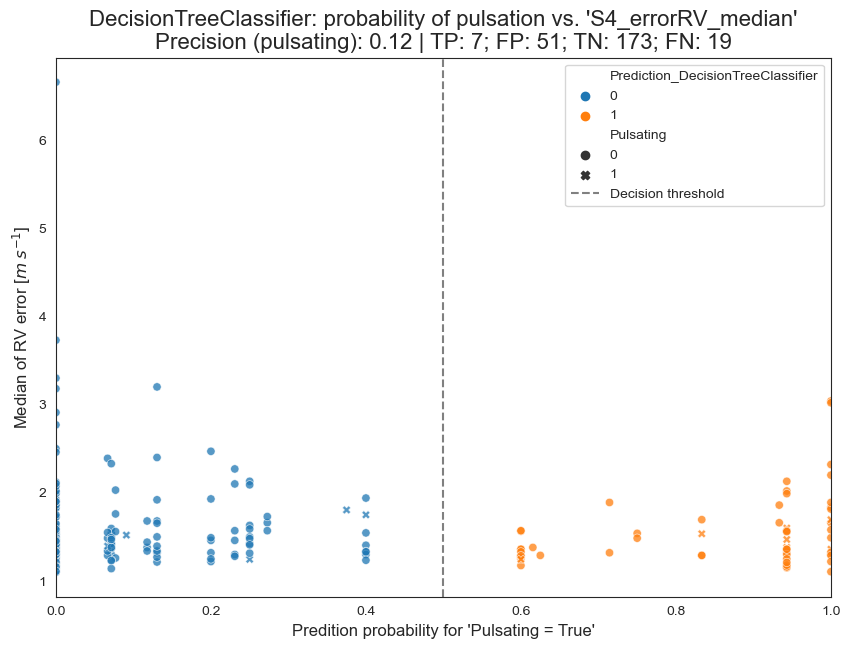

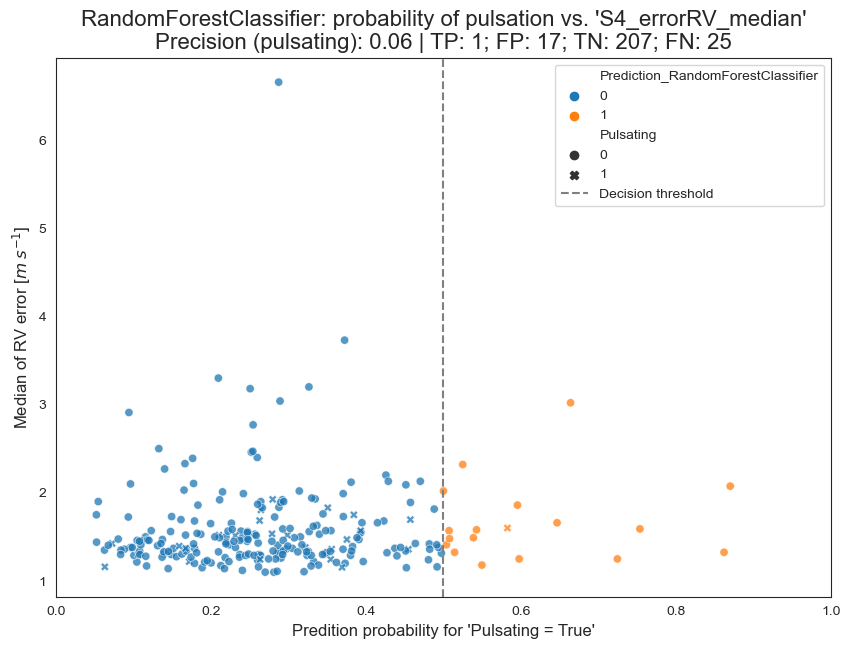

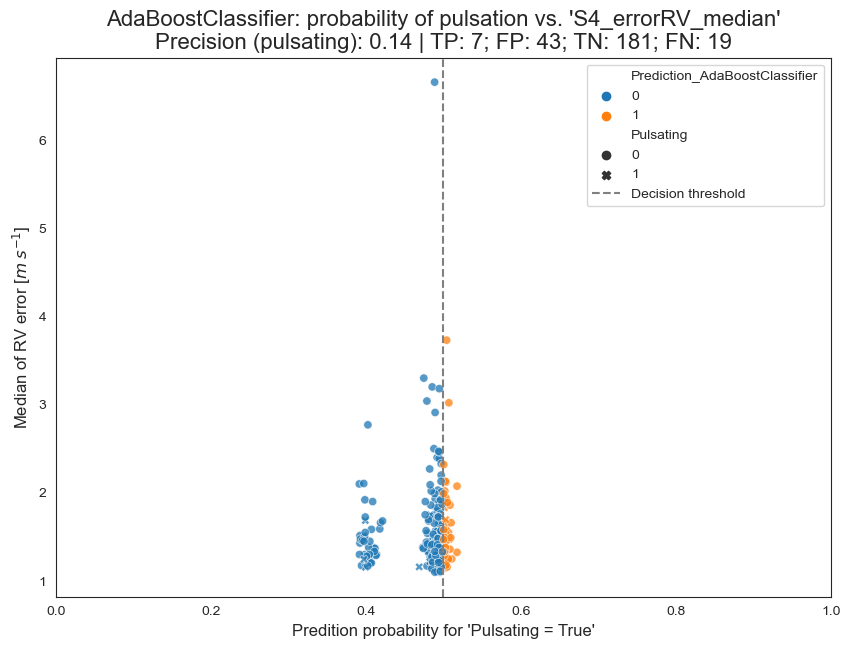

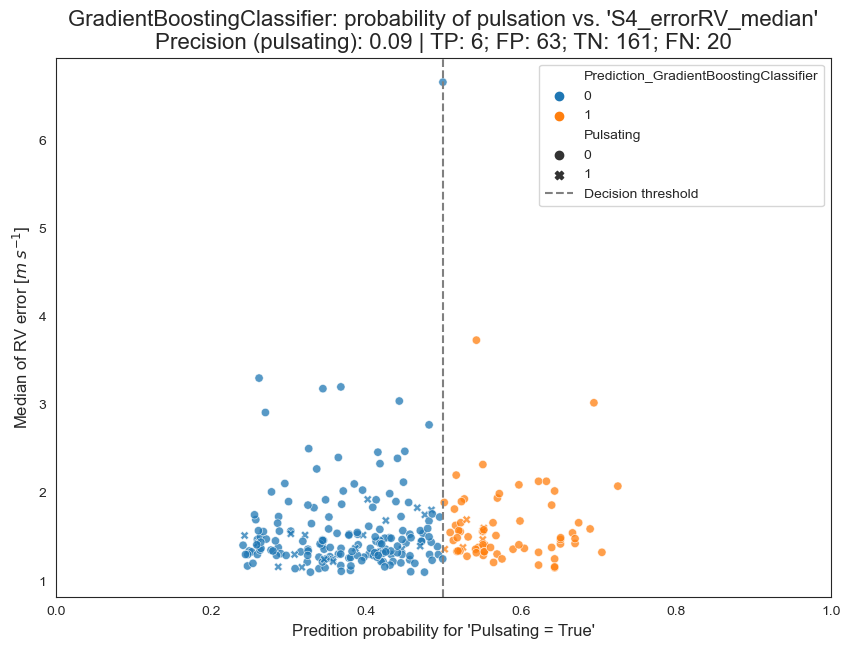

In [45]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'S4_errorRV_median'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Median of RV error [$m\;s^{-1}$]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_03_" + str(img_id).zfill(2) +"_PredProba_vs_MedianRVerror_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Standard deviation of RV error plots

In [46]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

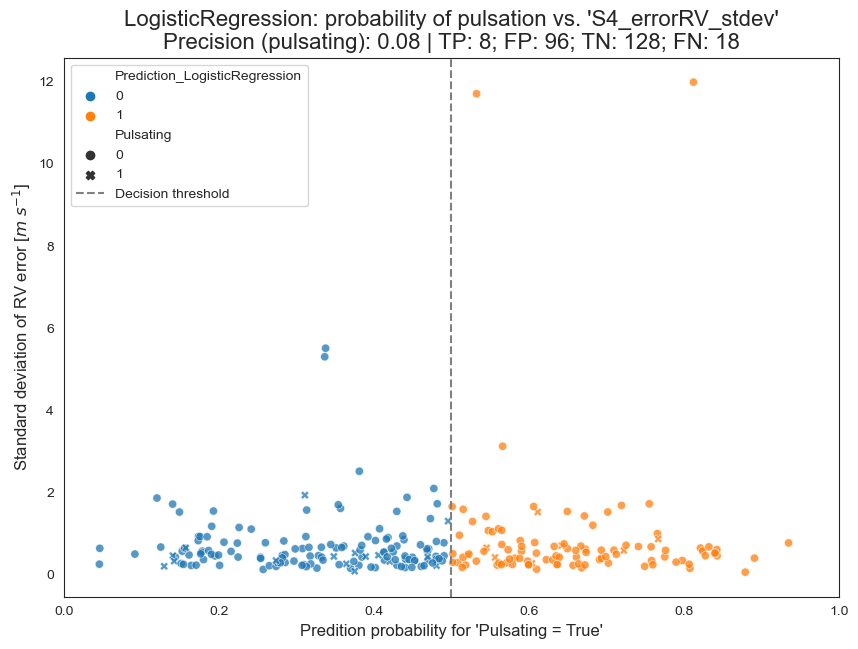

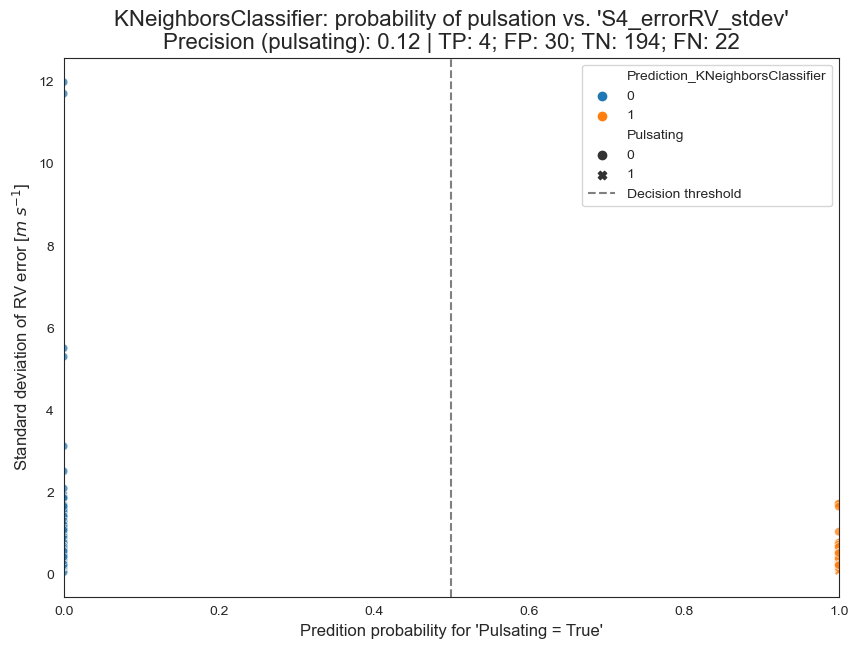

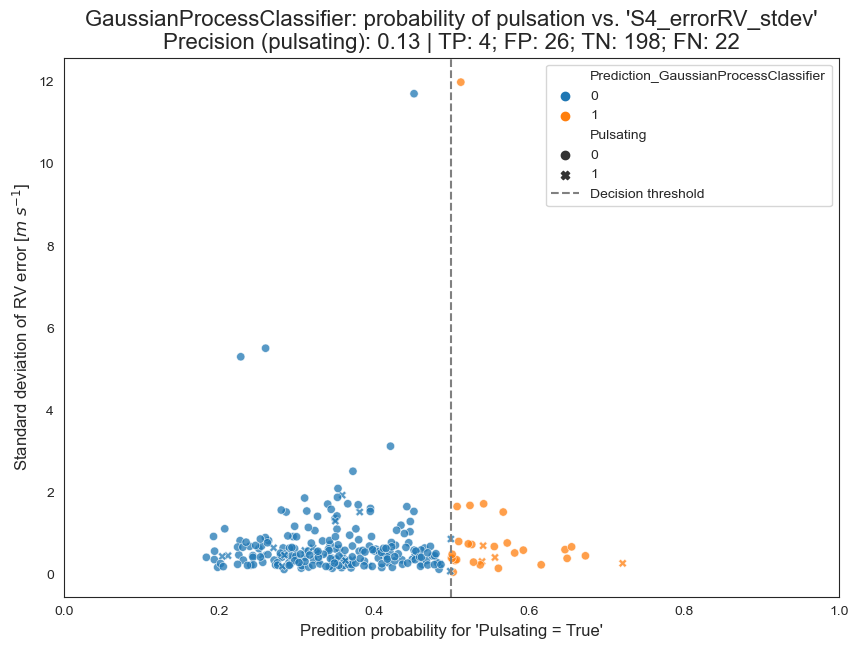

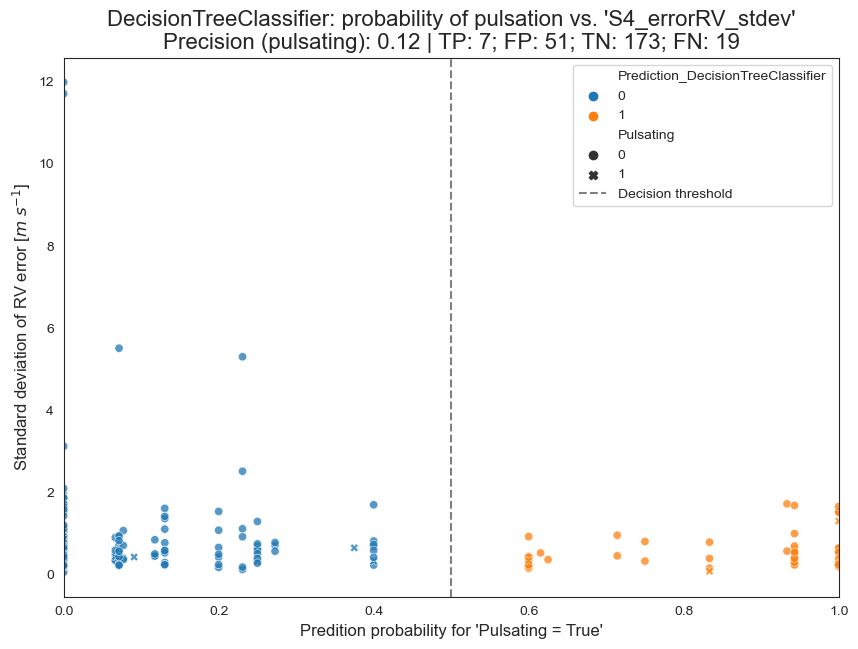

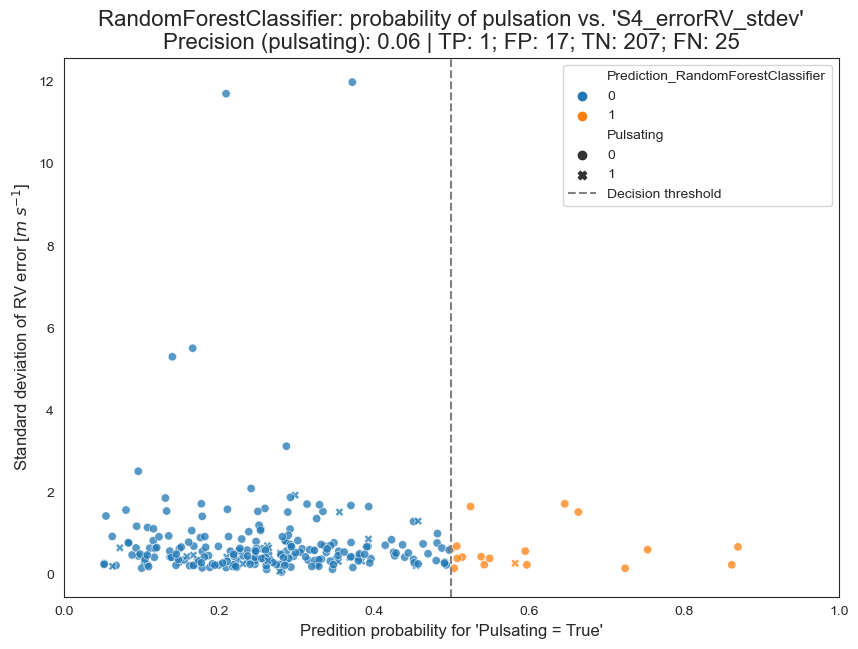

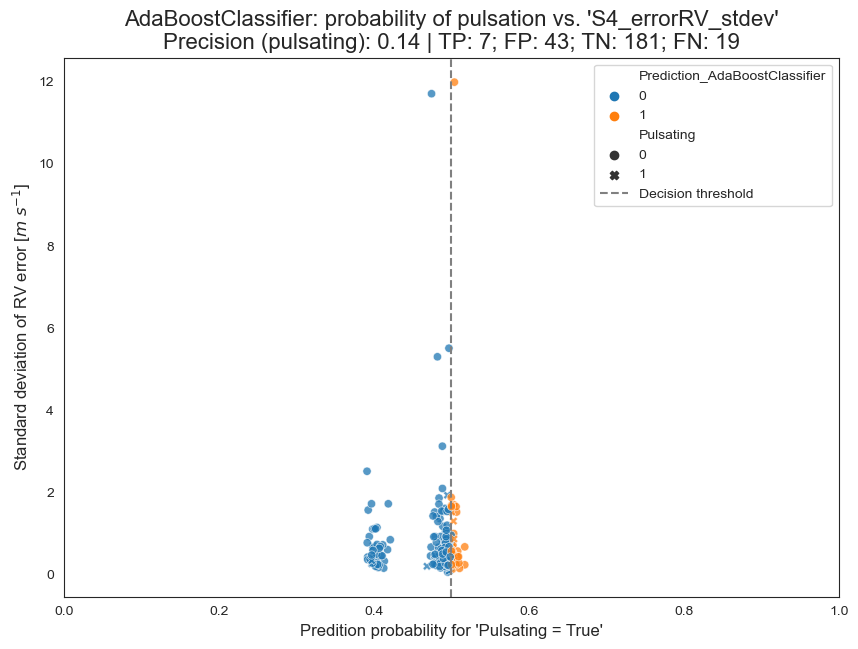

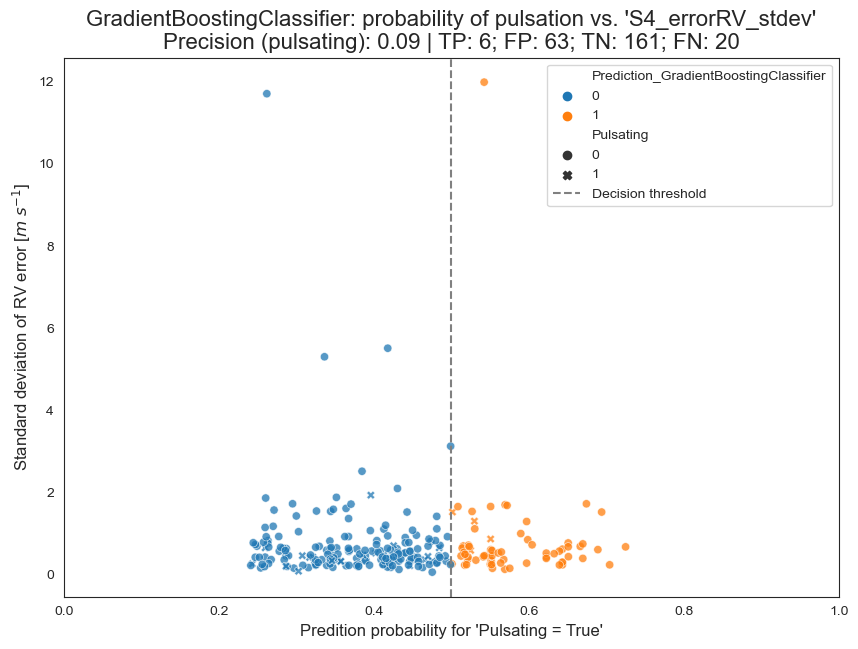

In [47]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'S4_errorRV_stdev'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Standard deviation of RV error [$m\;s^{-1}$]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_04_" + str(img_id).zfill(2) +"_PredProba_vs_StdevRVerror_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Number of points in the RV curve

In [48]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

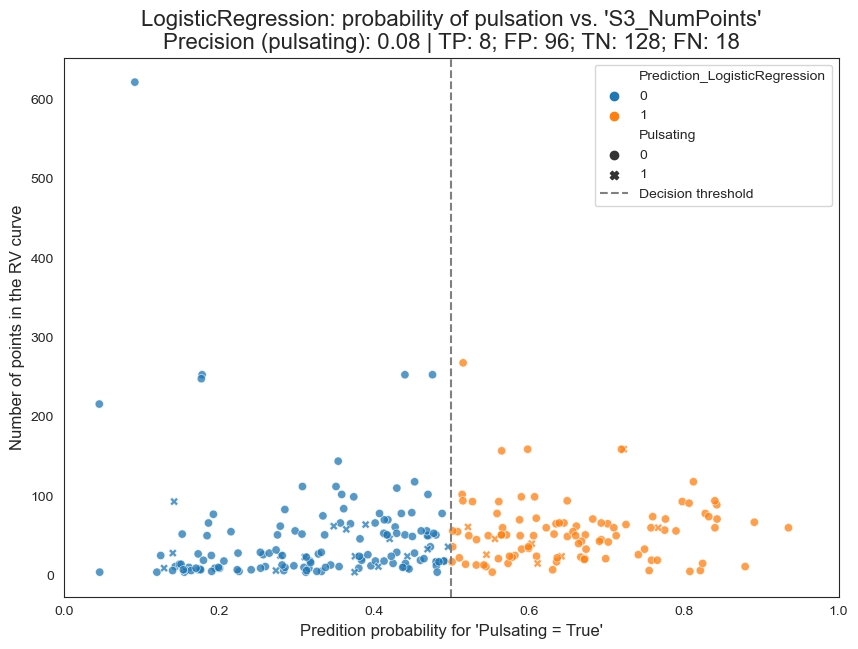

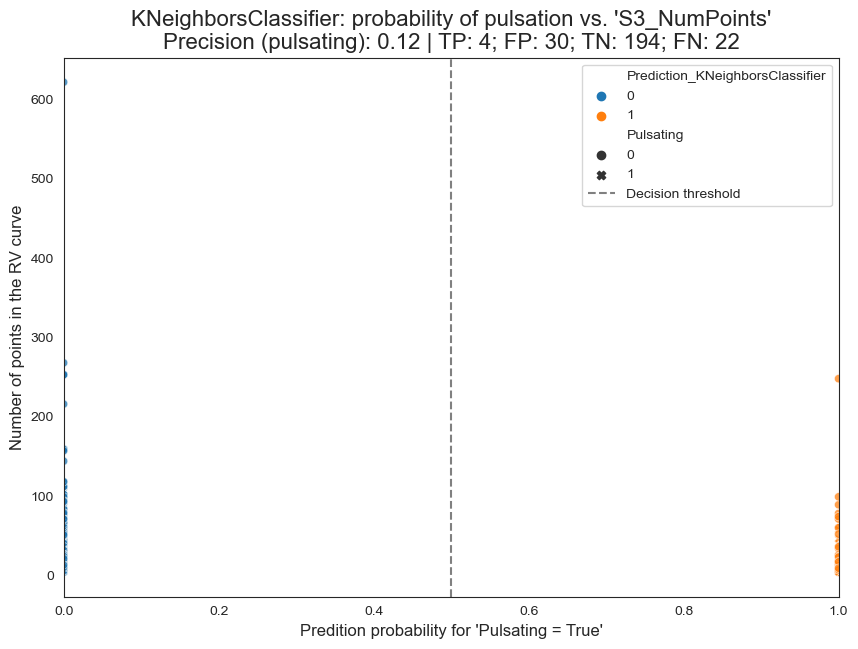

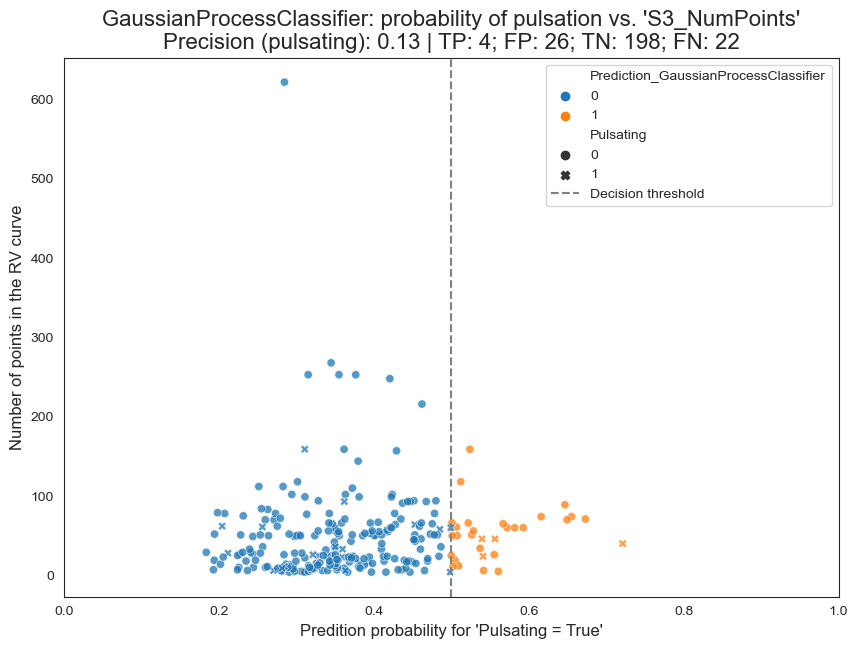

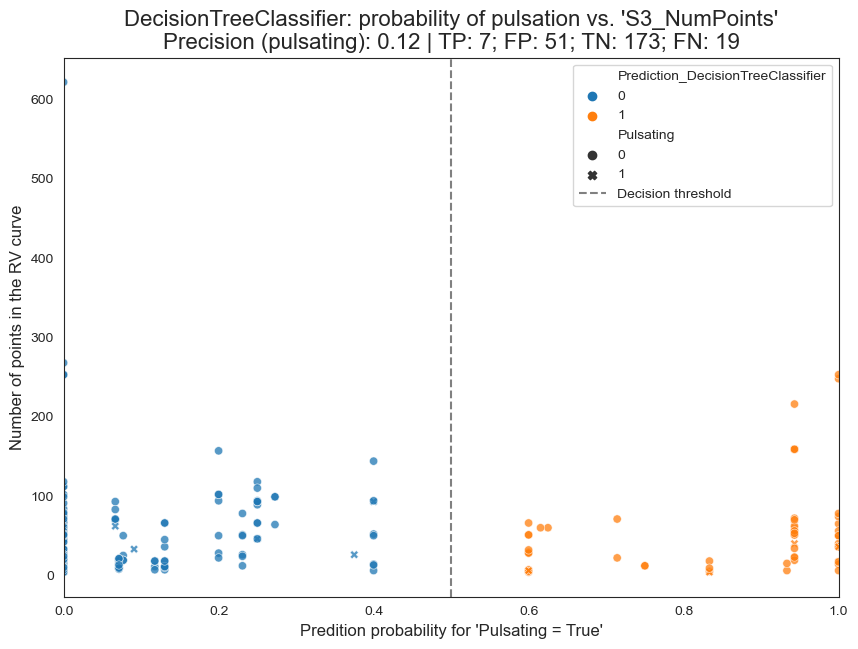

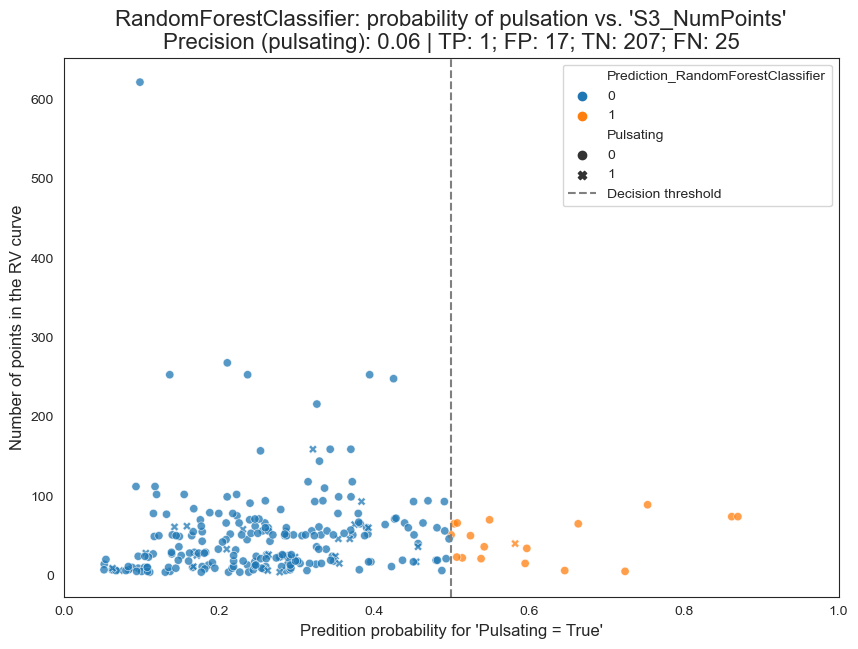

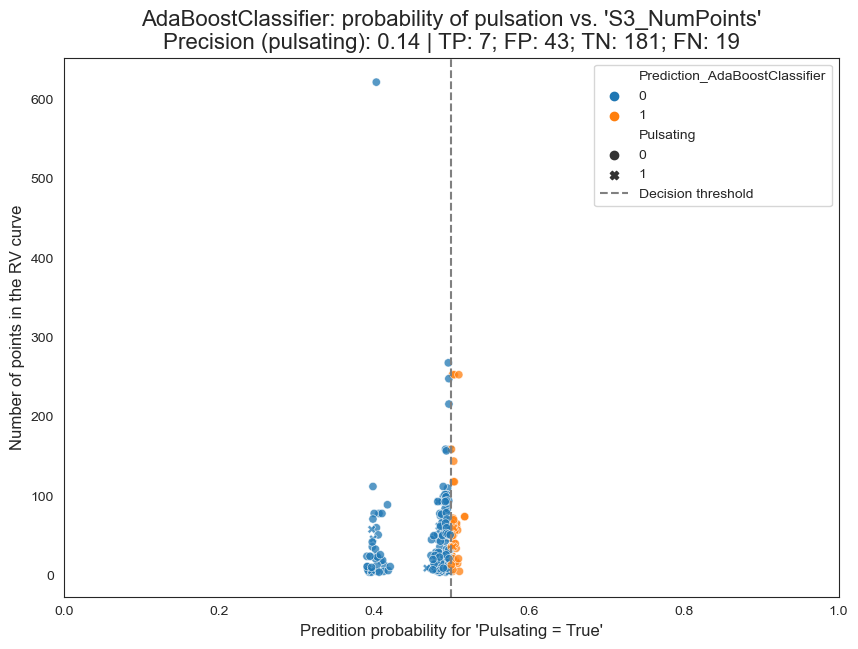

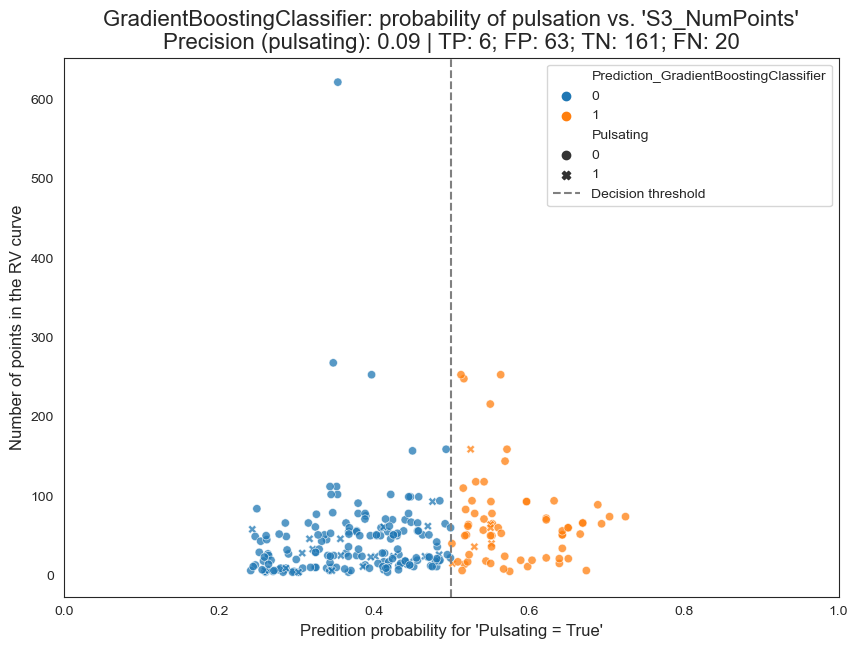

In [49]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'S3_NumPoints'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Number of points in the RV curve"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_05_" + str(img_id).zfill(2) +"_PredProba_vs_NumPoints_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Time baseline

In [50]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

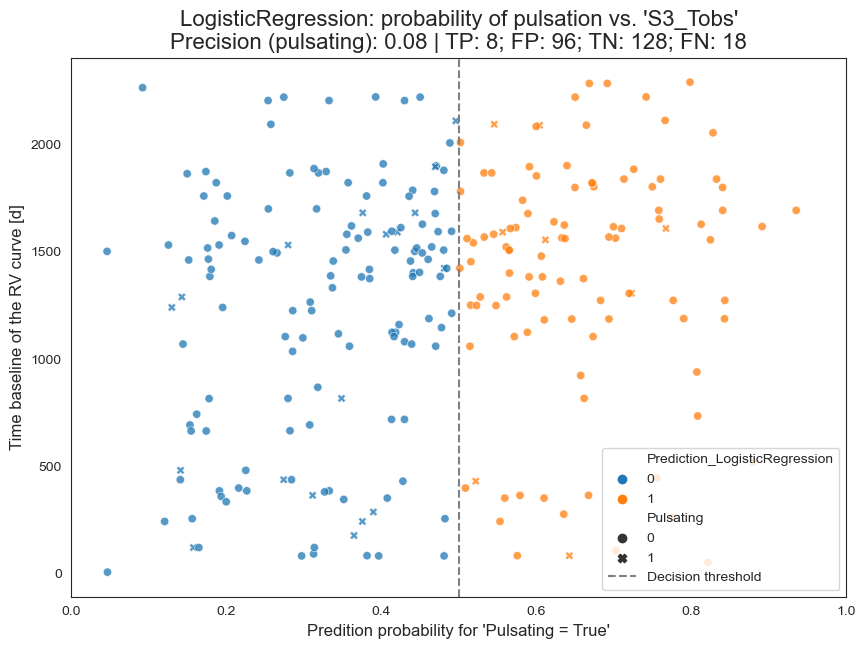

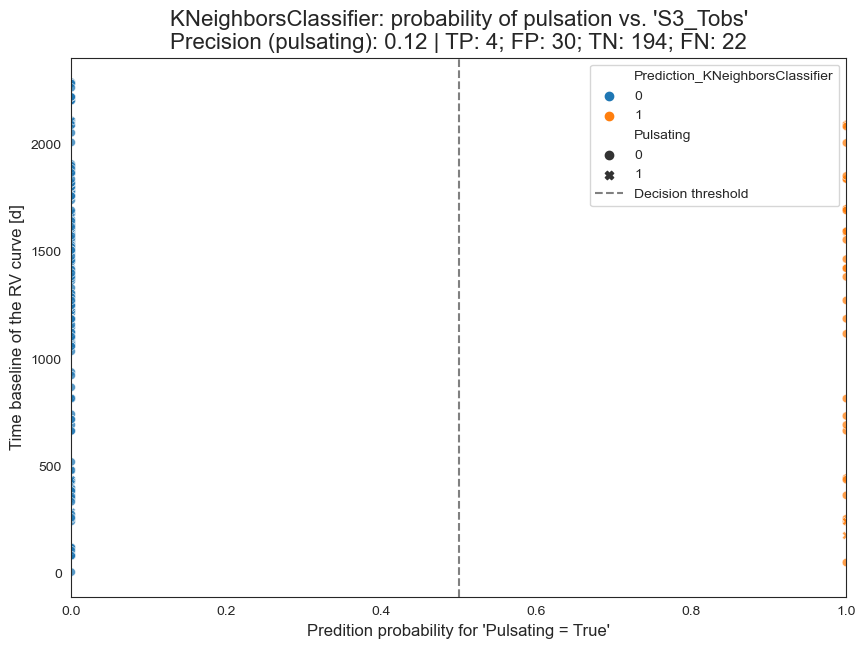

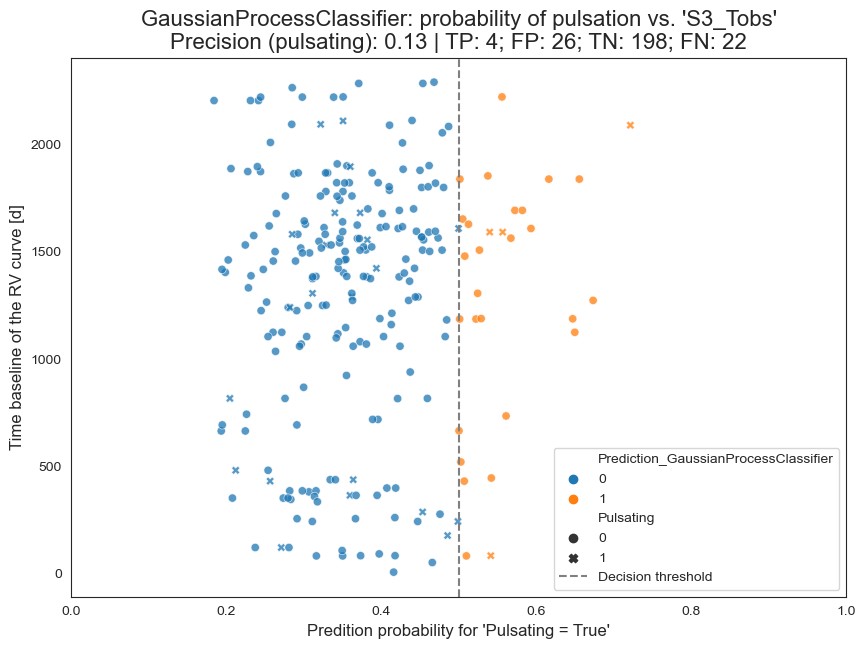

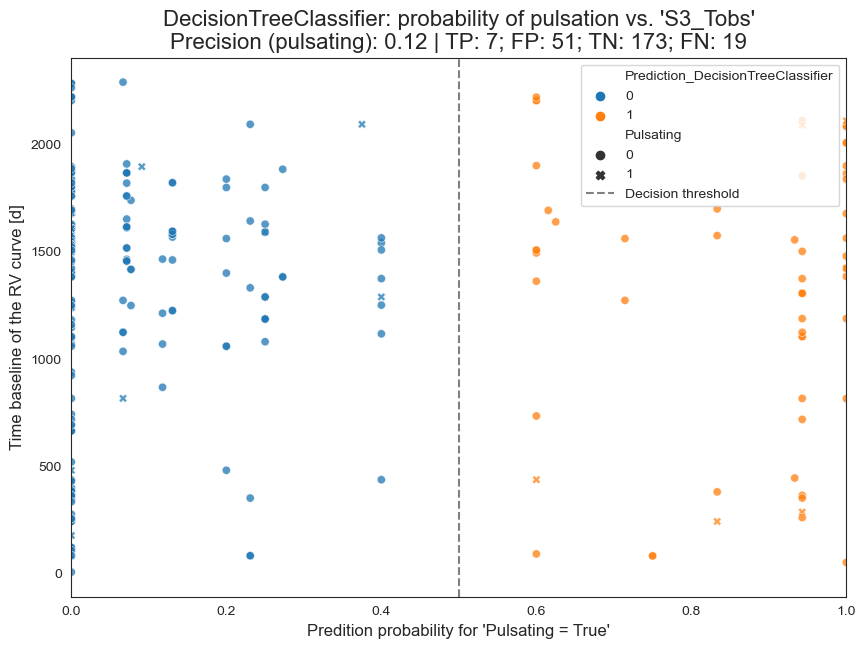

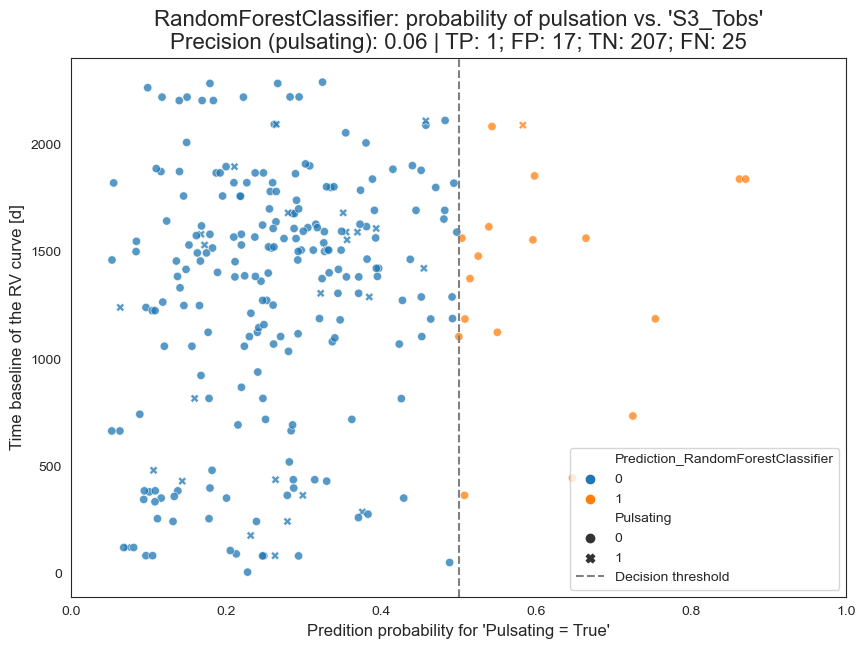

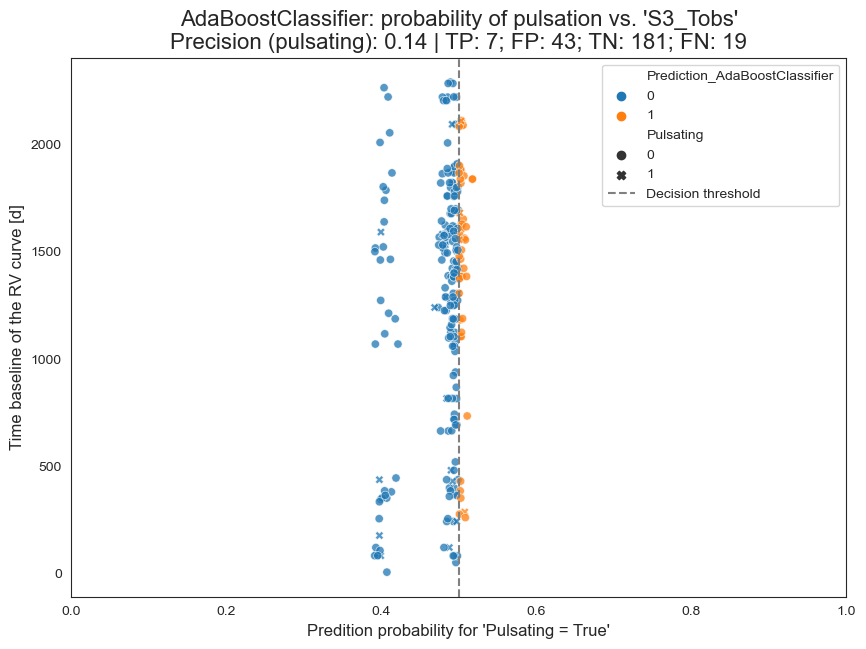

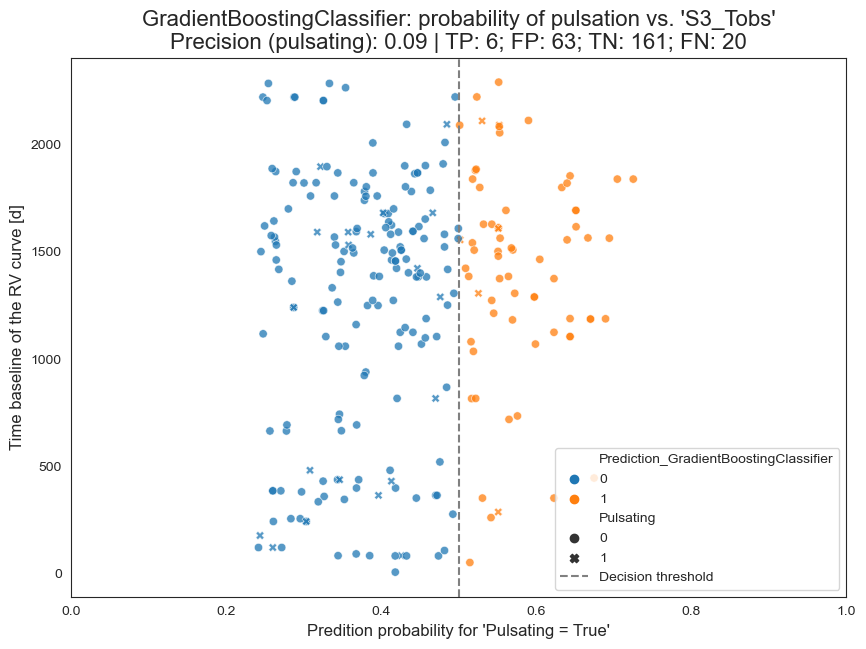

In [51]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'S3_Tobs'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Time baseline of the RV curve [d]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_06_" + str(img_id).zfill(2) +"_PredProba_vs_TimeBaseline_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Median of the sampling period

In [52]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

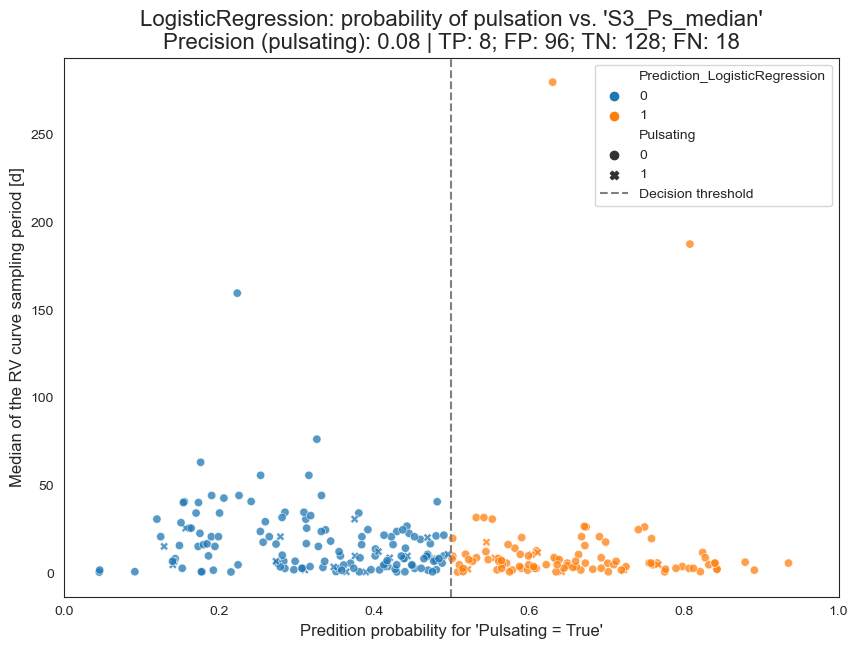

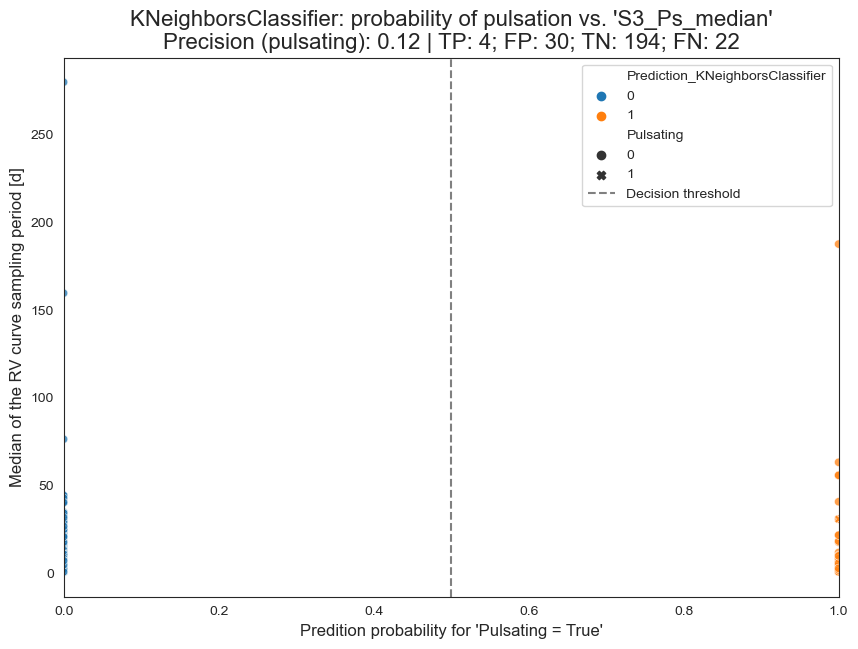

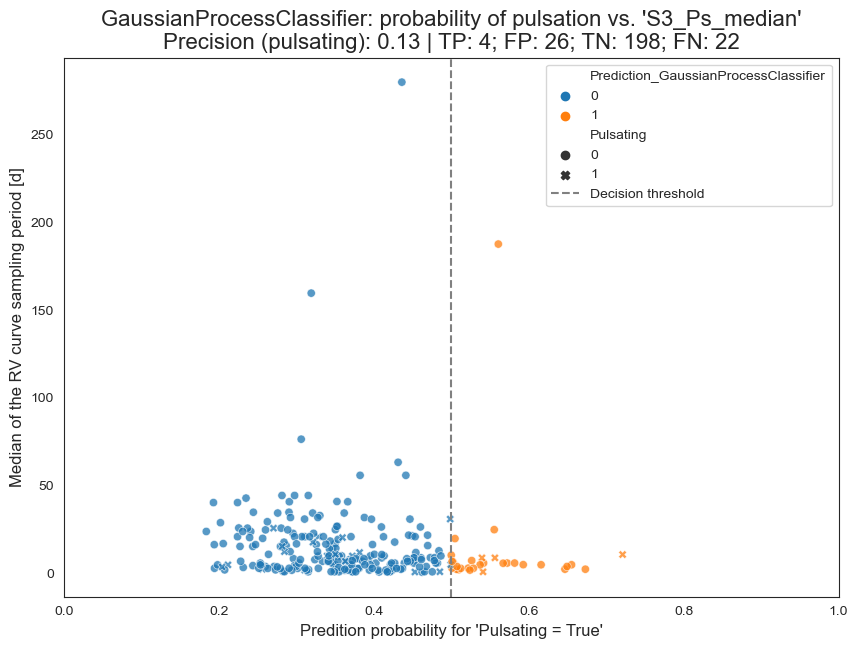

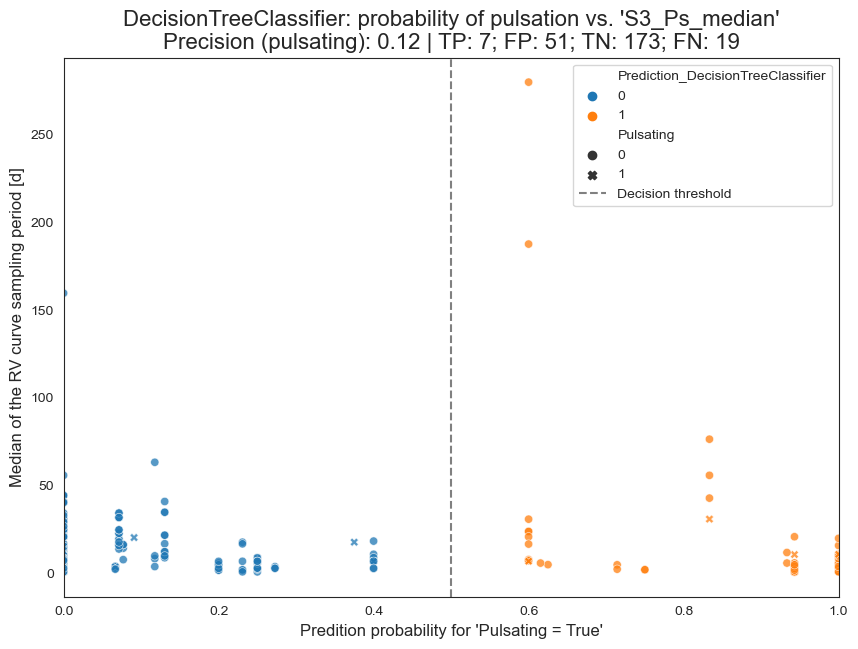

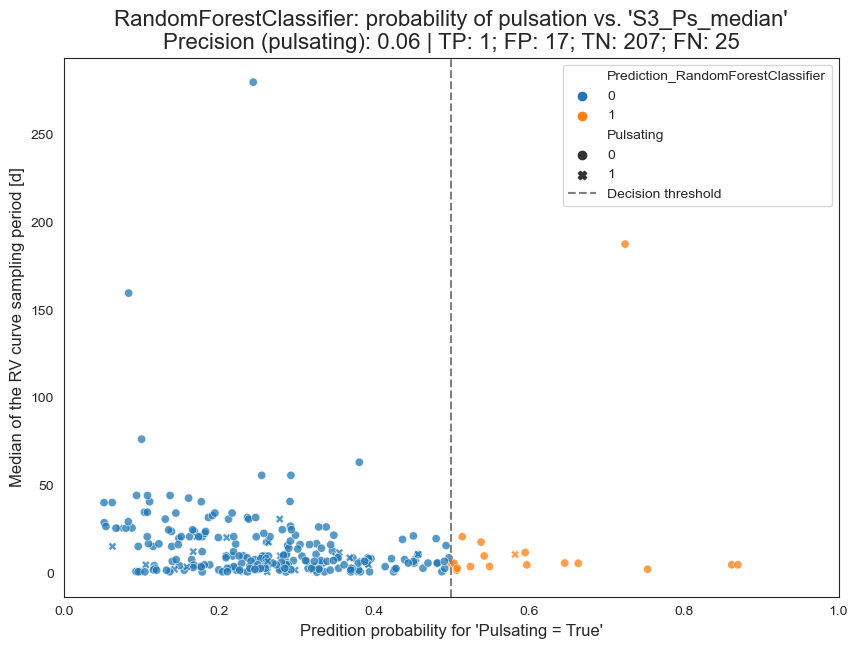

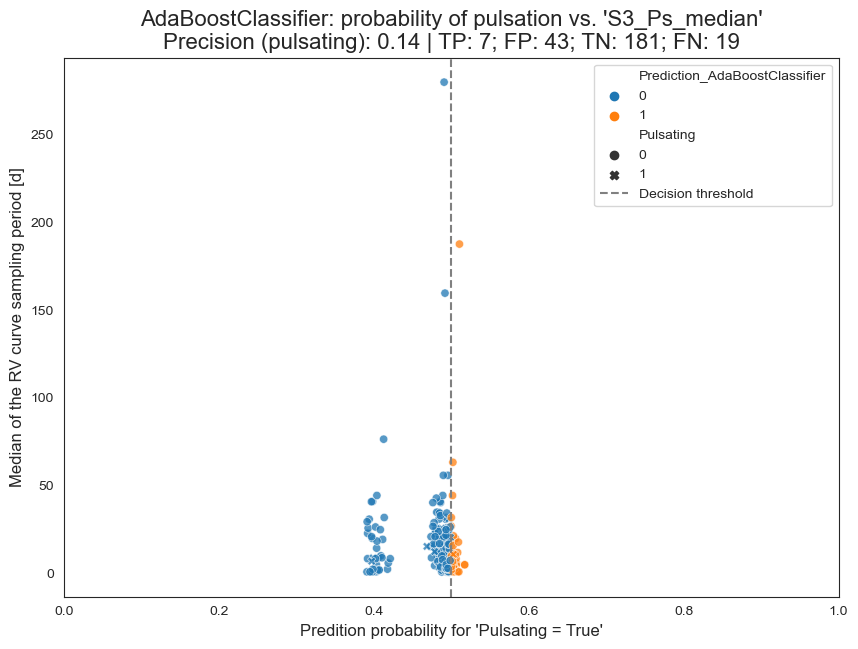

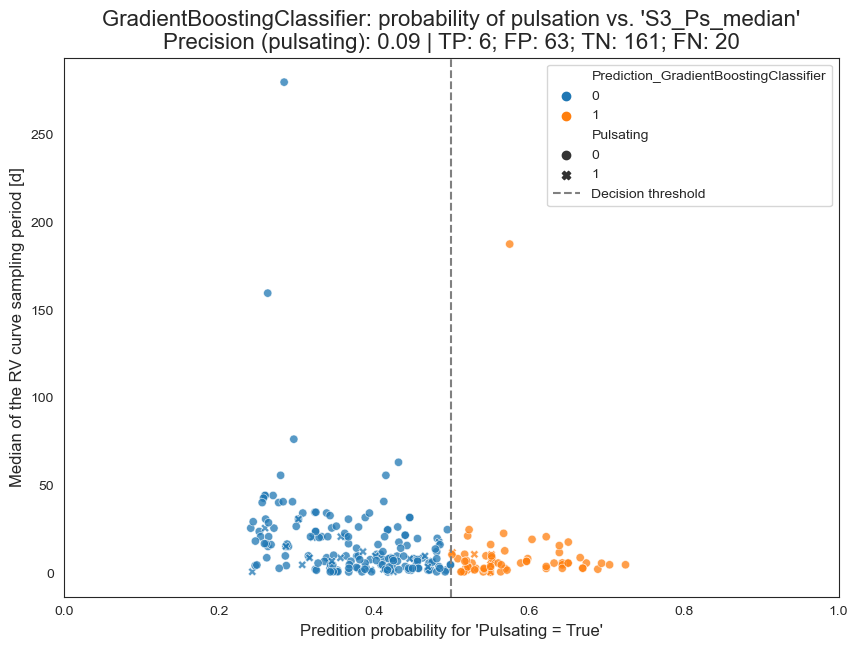

In [53]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'S3_Ps_median'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Median of the RV curve sampling period [d]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_07_" + str(img_id).zfill(2) +"_PredProba_vs_MedianSamplingP_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Standard deviation of the sampling period

In [54]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

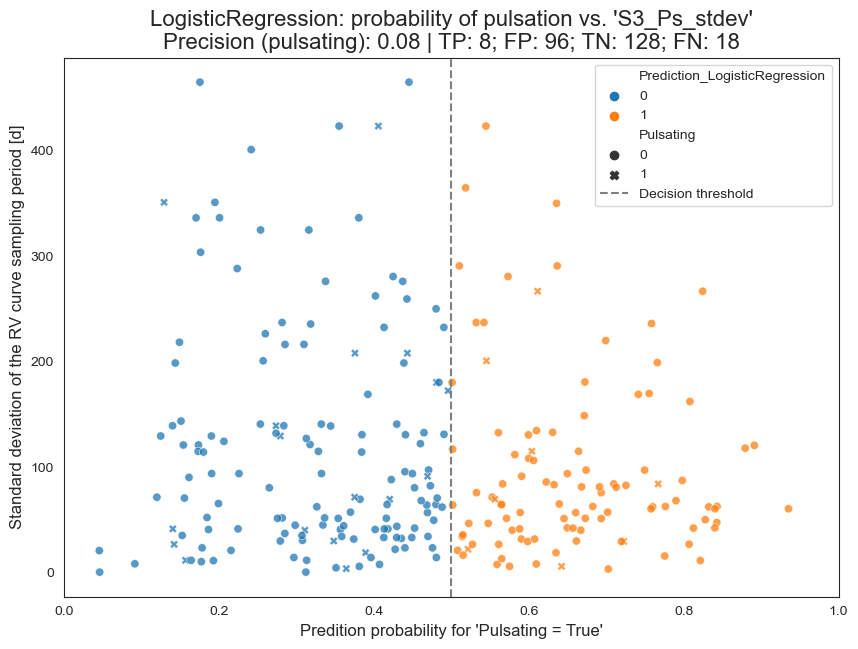

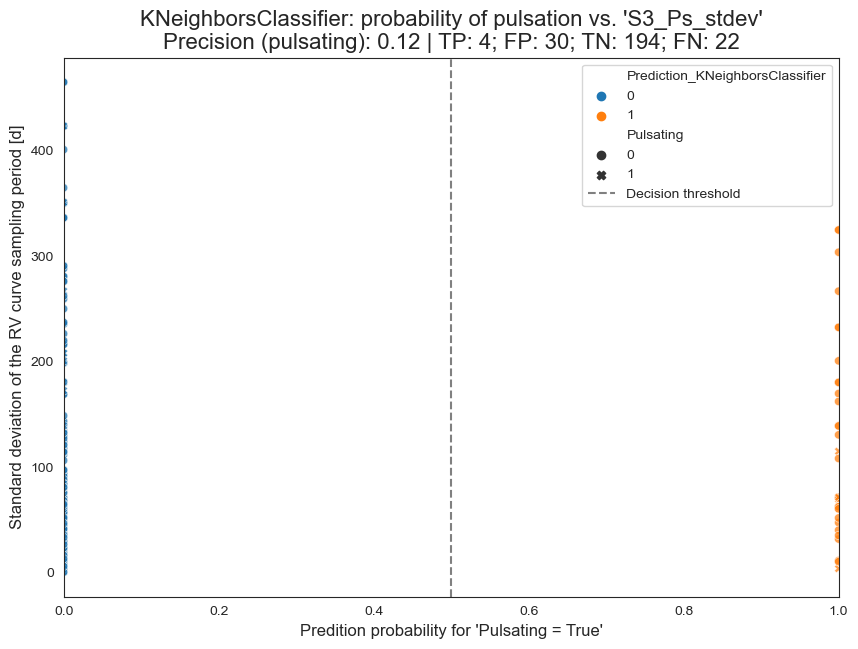

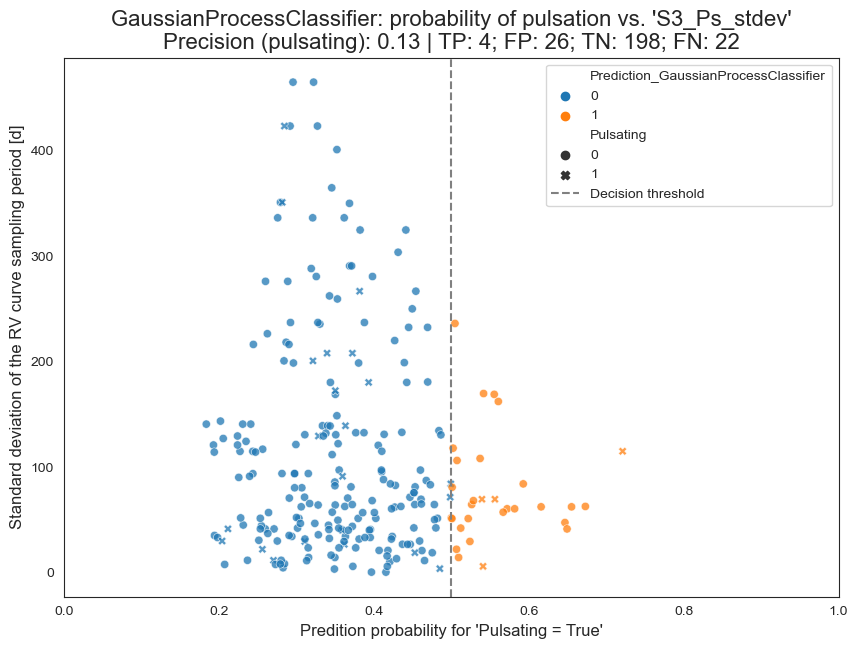

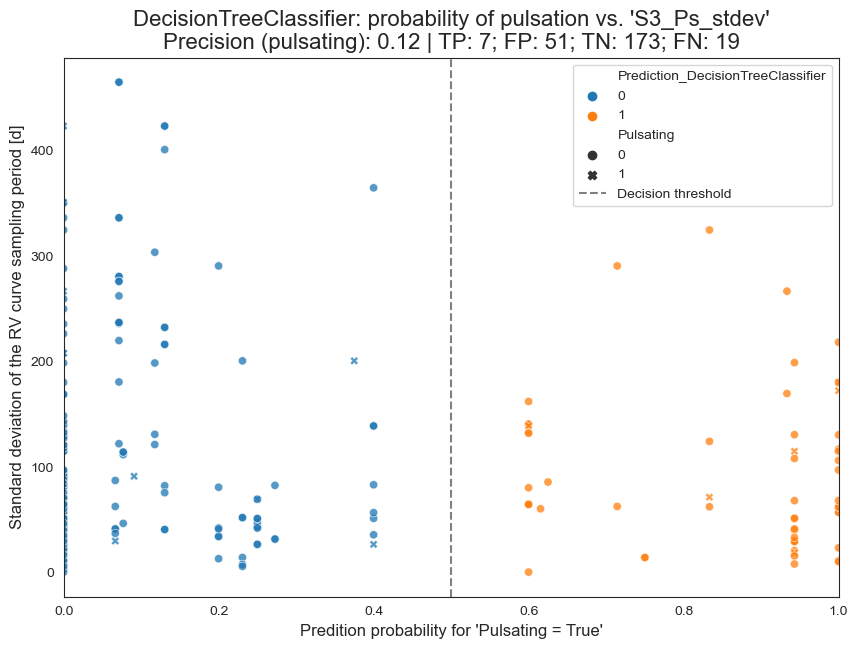

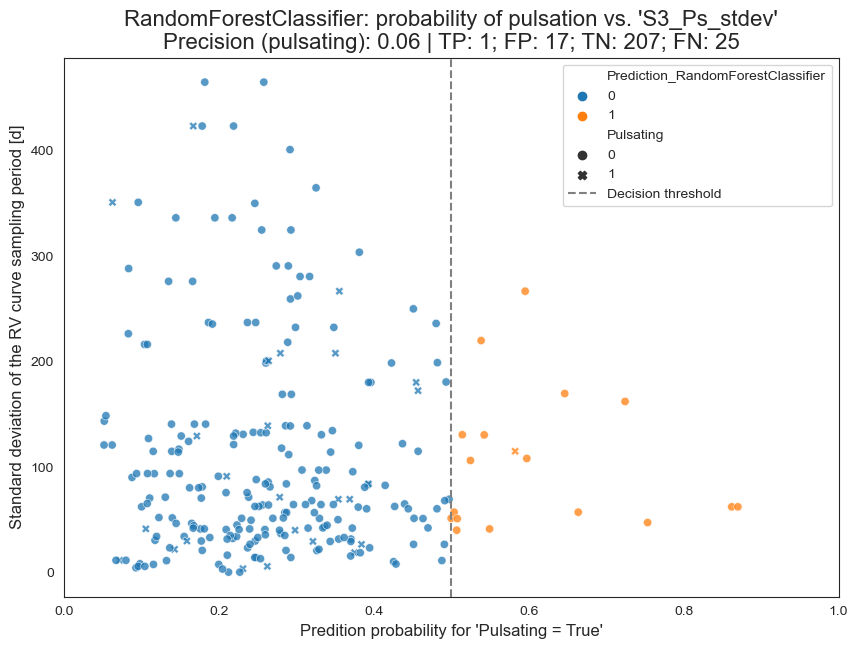

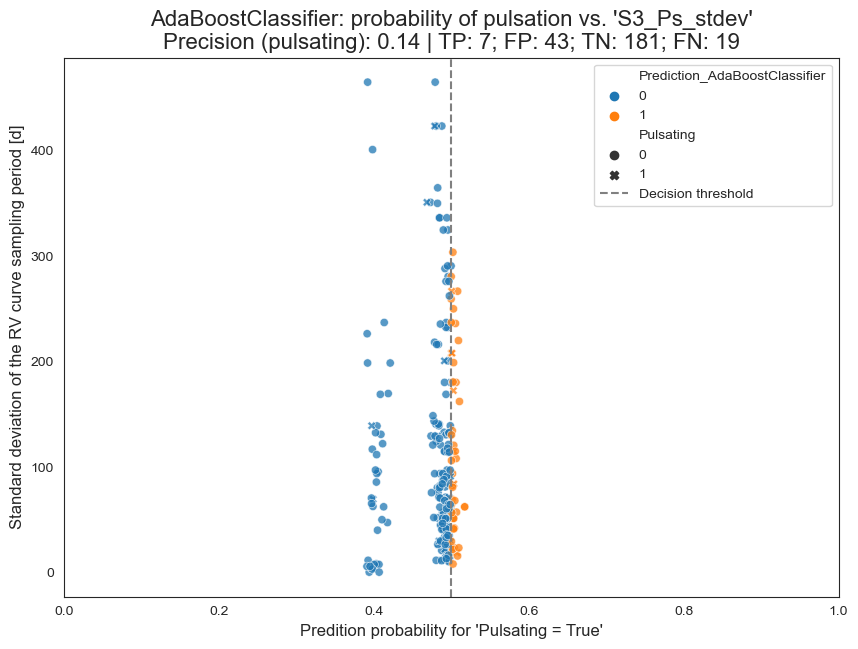

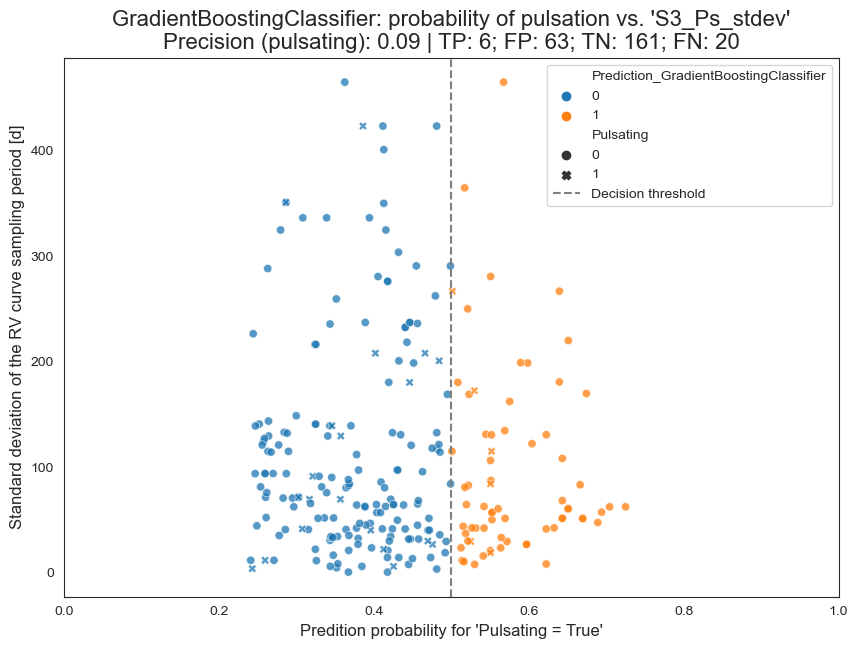

In [55]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'S3_Ps_stdev'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "Standard deviation of the RV curve sampling period [d]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_08_" + str(img_id).zfill(2) +"_PredProba_vs_StdevSamplingP_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### RMS of the RV curve

In [56]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

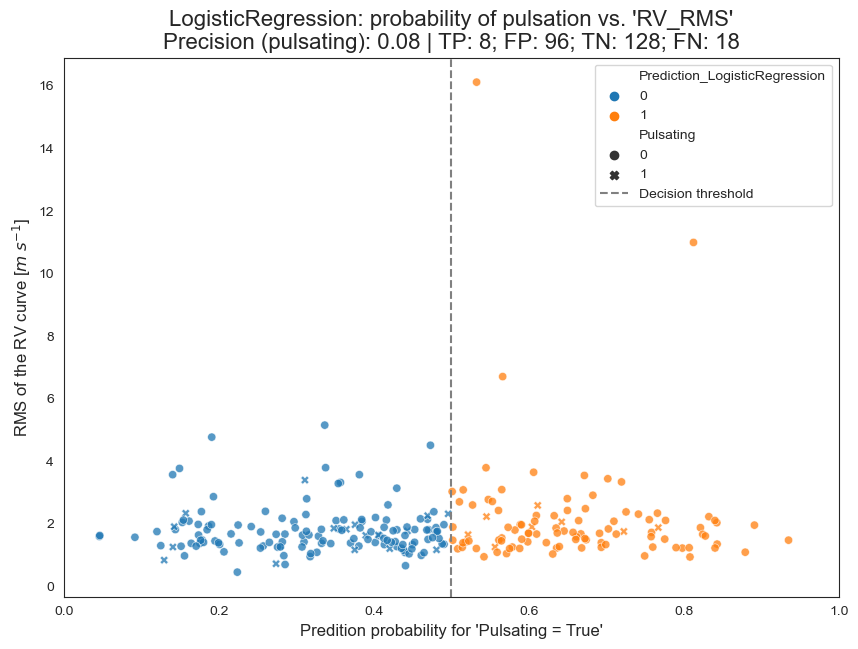

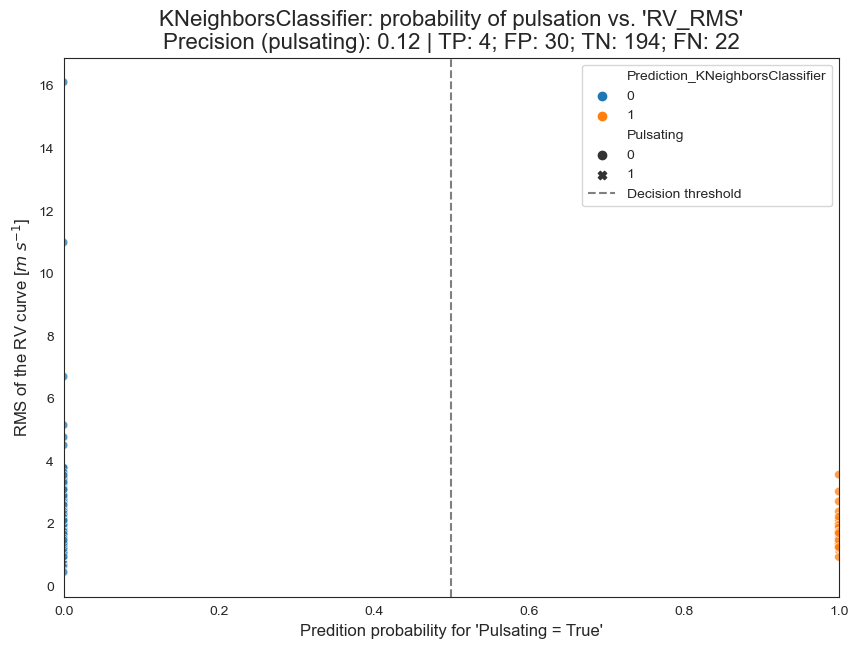

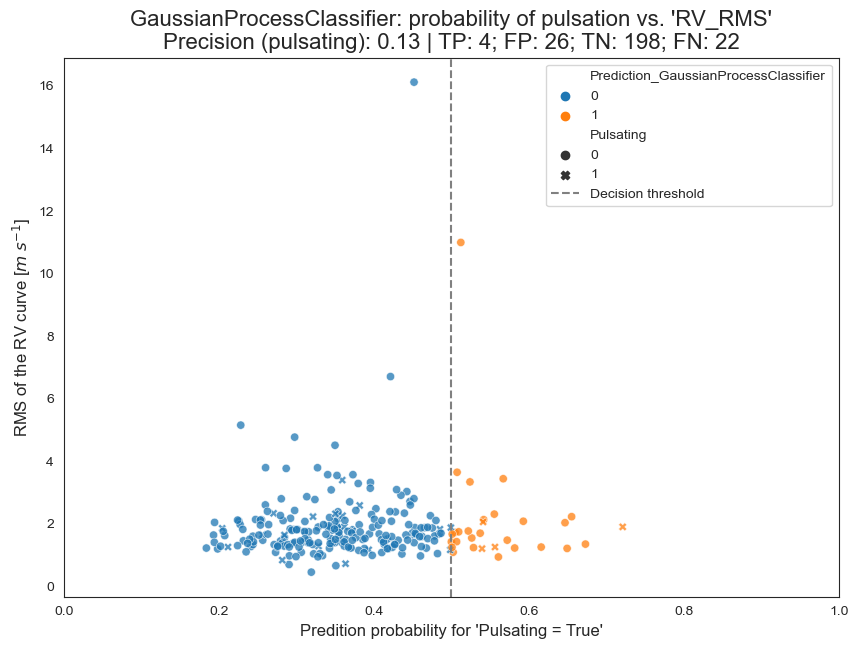

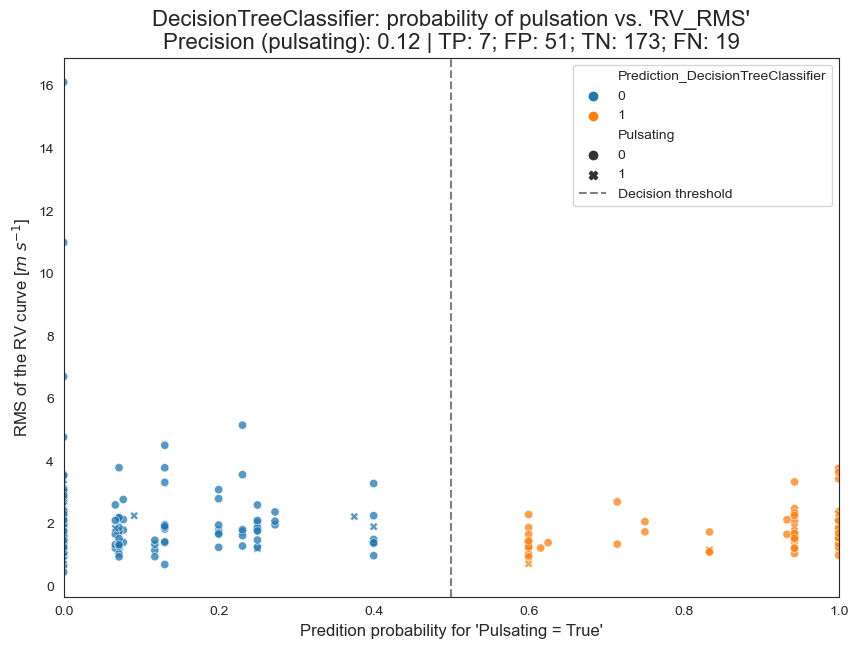

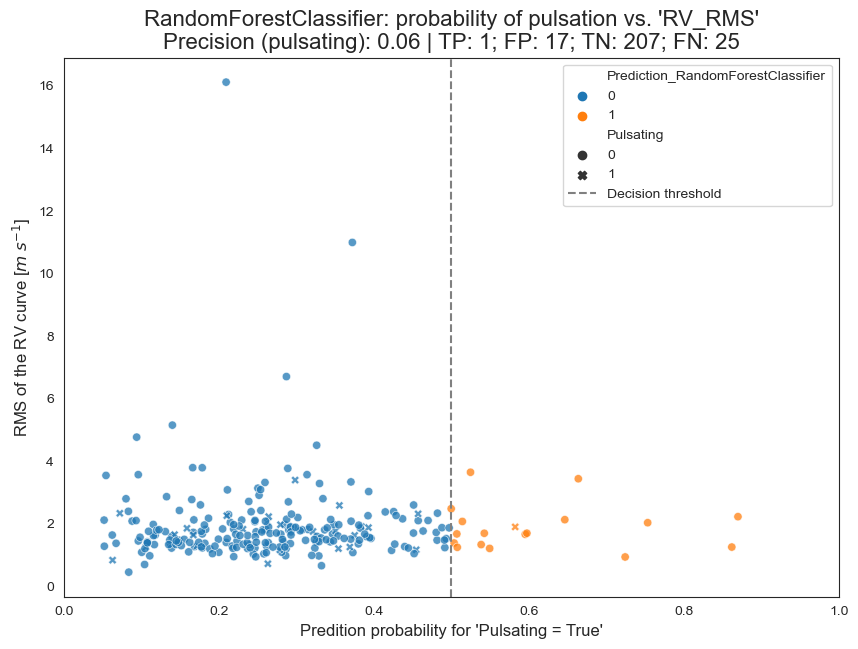

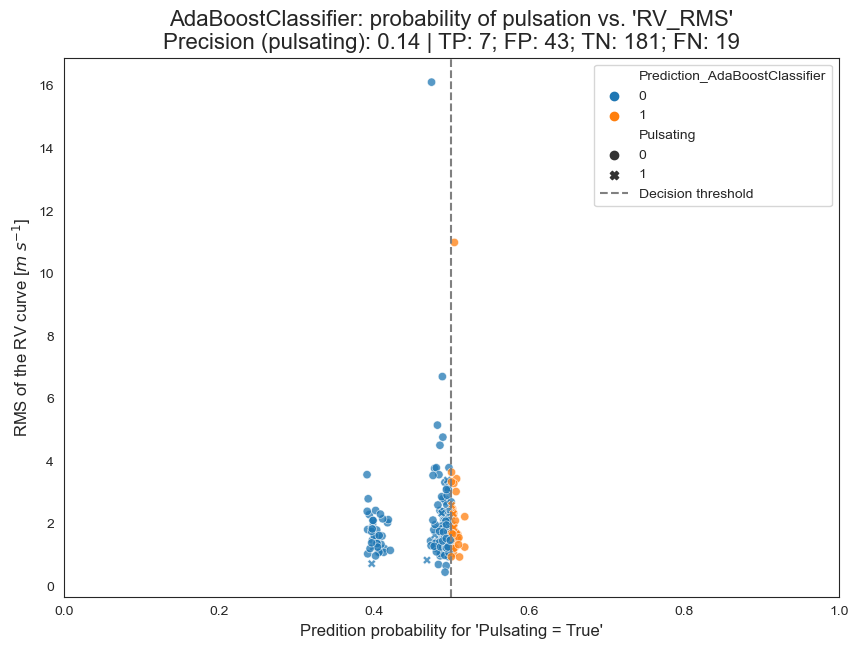

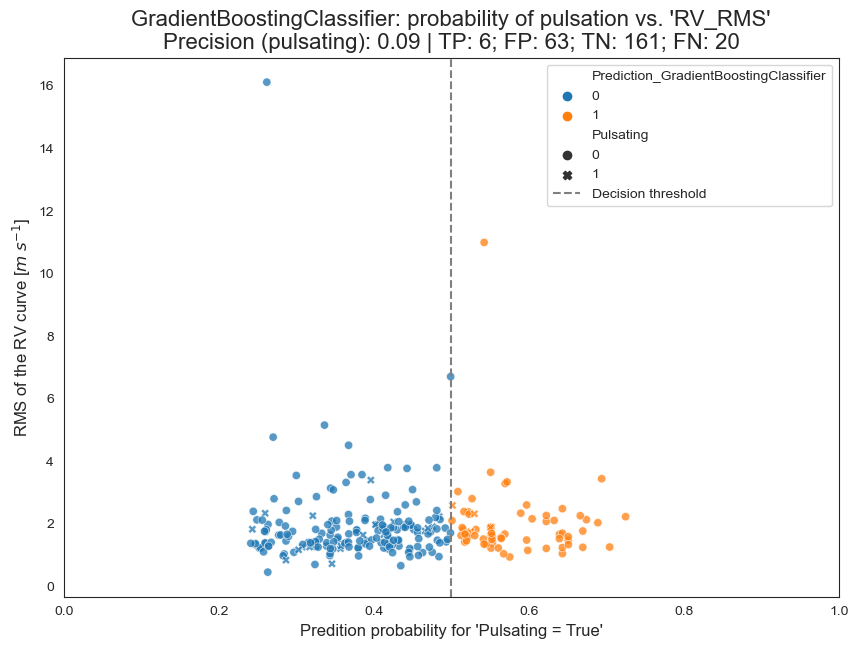

In [57]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    #clf_name = clf_list[0]
    y_var = 'RV_RMS'
    pred_col = 'Prediction_' + clf_name 
    true_col = 'Pulsating'
    prob_threshold = 0.50
    xlabel = "Predition probability for 'Pulsating = True'"
    ylabel = "RMS of the RV curve [$m\;s^{-1}$]"
    fig_title = clf_name + ": probability of pulsation vs. " + "'"+ y_var + "'"
    fig_filename = IMG_FOLDER + "ML_55_09_" + str(img_id).zfill(2) +"_PredProba_vs_RVCurveRMS_" + clf_name + ".jpg"

    pred_proba_plot(
        data=data, clf_name=clf_name, y_var=y_var,
        pred_col=pred_col, true_col=true_col, prob_threshold=prob_threshold,
        xlabel=xlabel, ylabel=ylabel, fig_title=fig_title, fig_filename=fig_filename
    )
    plt.plot();

### Distributions of `predict_proba`

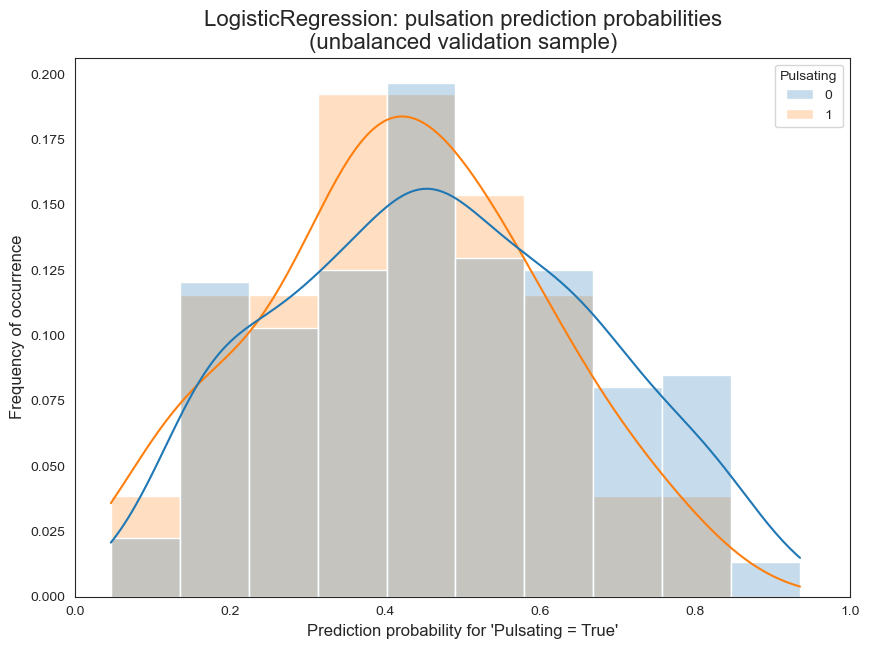

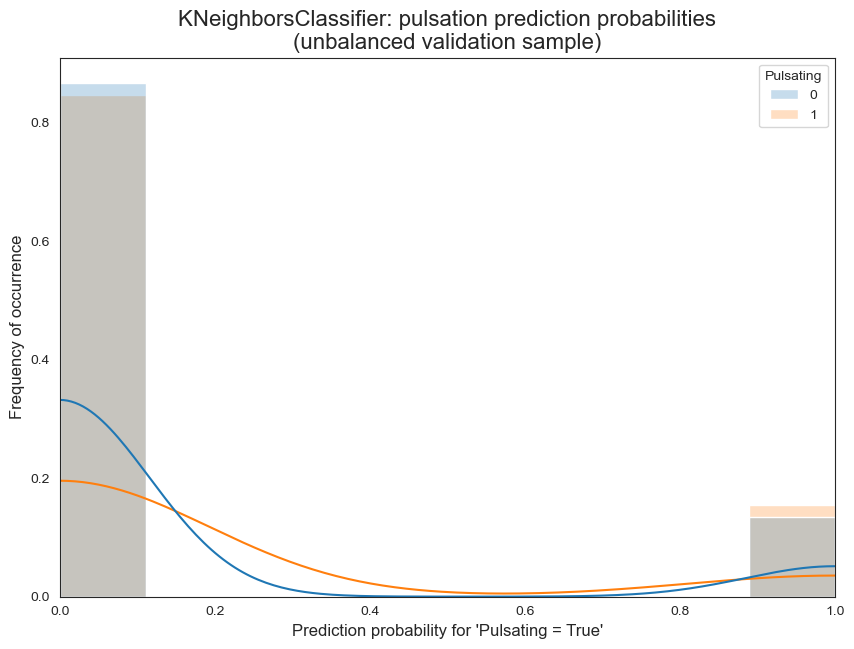

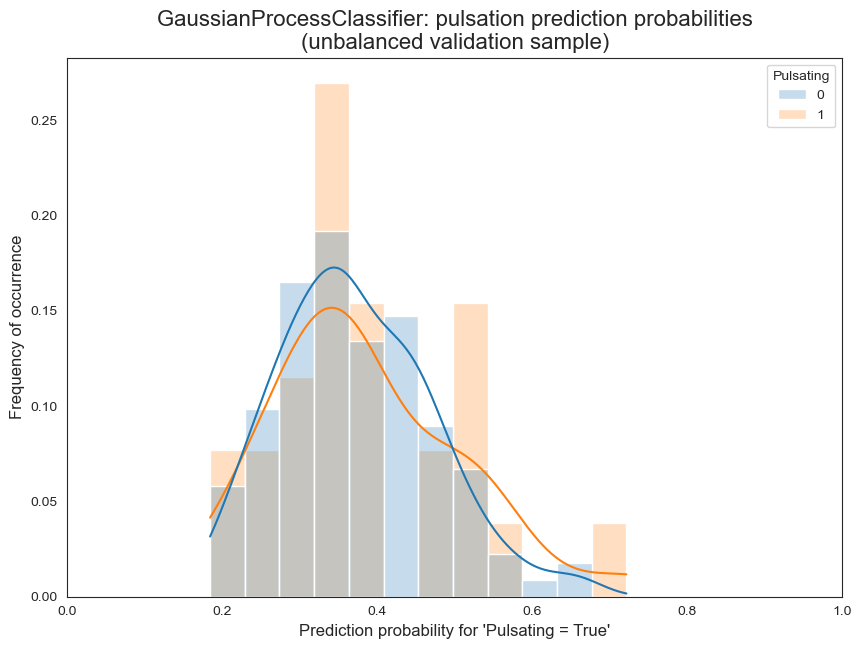

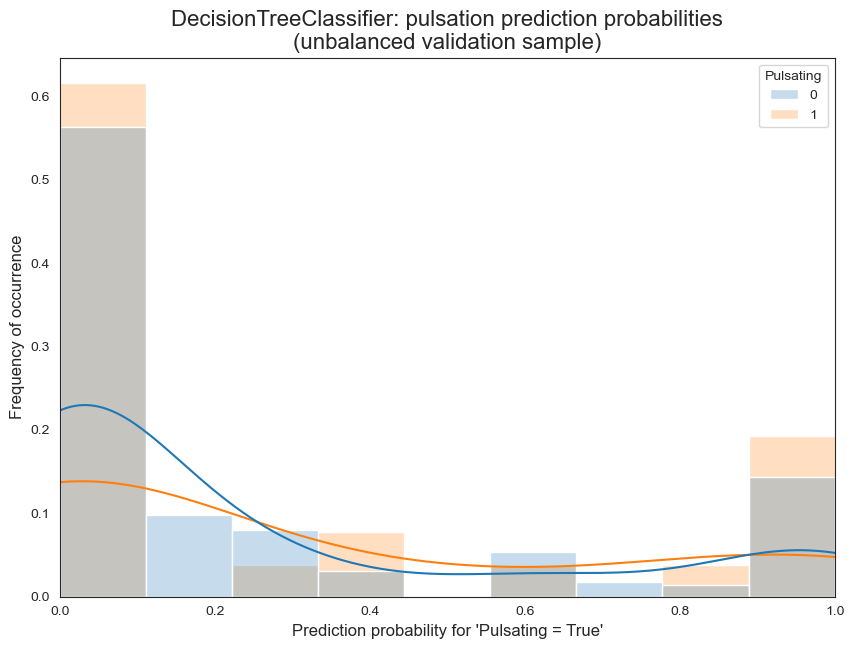

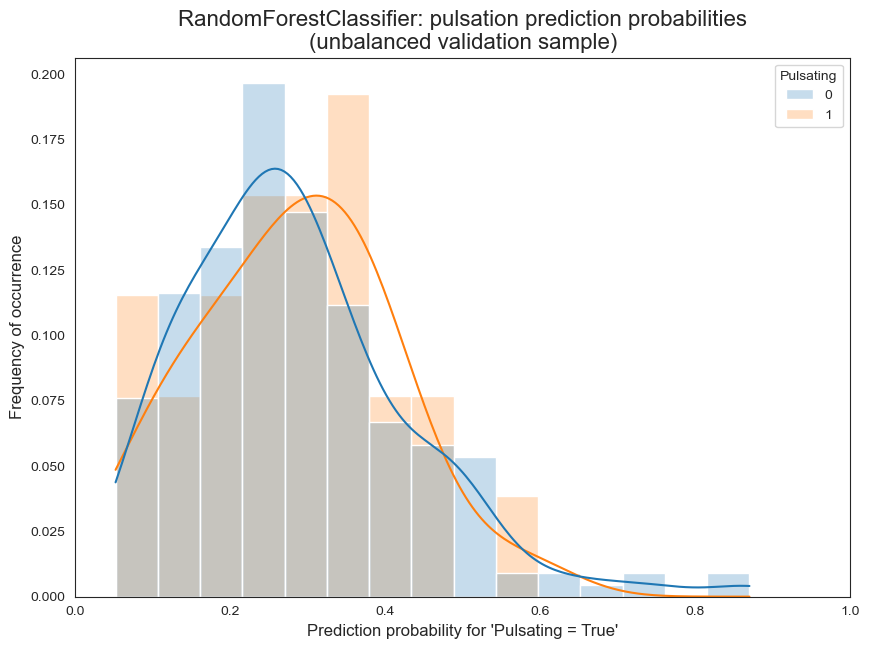

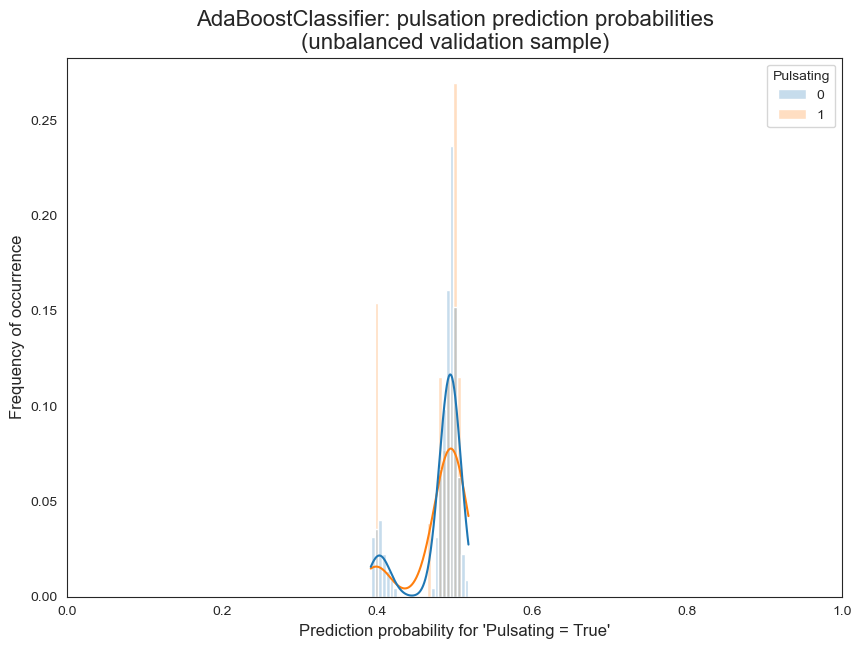

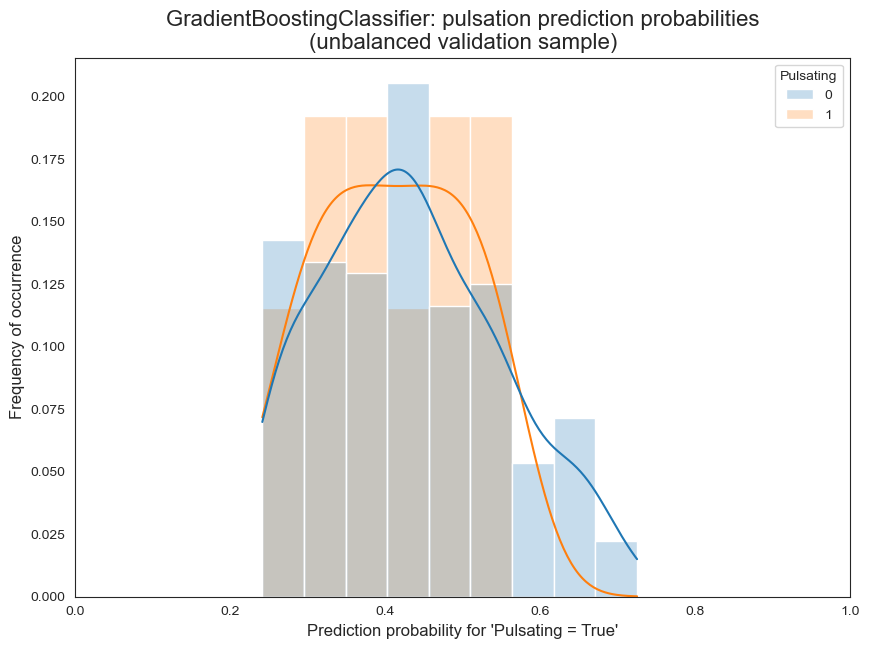

In [58]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = val_pred_comp.copy()
    x_col = 'PredictionProb_' + clf_name
    hue_col = 'Pulsating'
    varname = "Prediction probability for 'Pulsating = True'"
    fig_title = clf_name + ": pulsation prediction probabilities\n(unbalanced validation sample)"
    fig_filename = IMG_FOLDER + "ML_55_10_" + str(img_id).zfill(2) +"_ValidationPredictionProb_" + clf_name + ".jpg"
    stat='proportion'
    kde = True
    hist_fill=True
    normalized=True
    
    compare_dist(data, x_col, hue_col=hue_col,
                 varname=varname, fig_title=fig_title,
                 fig_filename=fig_filename,
                 stat=stat, kde=kde, hist_fill=hist_fill)


## Summary

**RESULTS:**

- We have seen the prediction probabilities assigned by each classifier to each data point in the validation set, comparing those values with the following characteristics of the stars:
  - Amplitude of the pulsation signal.
  - Frequency of the pulsation signal.
  - Median of RV error of the signal.
  - Standard deviation of RV error of the signal.
  - Number of points in the RV curve.
  - Time baseline (`T_obs`).
  - Sampling period median.
  - Sampling period standard deviation.
- In general, we have seen no correlation at all between misclassifications and any of those variables, for none of the classifiers.

**CONCLUSIONS:**

- None of the classifiers does a good job for the validation sample.
- Changing the prediction probability threshold will not help to improve the situation, either.
- Hence, we will just choose two classifiers to try to improve its performance:
  - `GaussianProcessClassifier`: because it is the one giving the best precision value.
  - `DecisionTreeClassifier`: because its easy interpretability, and because it should be easy to prevent the overfitting that it is suffering.